In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import scipy.stats as st
import matplotlib.patches as patches
import matplotlib.dates as mdates

# Prepare data

In [2]:
# Read in UK data
df_uk = pd.read_csv('../data/UK_consolidated_df.csv')

# Convert to quarterly
df_uk['date'] = pd.to_datetime(df_uk['date'])
df_uk = df_uk[df_uk['date'].dt.month.isin([3, 6, 9, 12])]

# First difference inflation rate
df_uk['infl_rate_diff'] = df_uk['infl_rate'].diff()
df_uk['ppi_diff'] = df_uk['ppi'].diff()

# Drop rows with missing values due to differencing
df_uk = df_uk.dropna()

# Reorder columns
df_uk = df_uk[['date', 'infl_rate', 'infl_rate_diff', 'ppi_diff', 'gdp_pct_change', 'int_3m', 'cons_conf', 'unm_rate']]

df_uk

date  infl_rate  infl_rate_diff  ppi_diff  gdp_pct_change    int_3m  \
4   1986-06-01   0.000000       -0.001035  0.000000        1.219277   9.82292   
7   1986-09-01   0.005113        0.005113  0.234957        1.735118  10.18892   
10  1986-12-01   0.003021       -0.002091  0.391599        3.384261  11.40421   
13  1987-03-01   0.001992       -0.001029  0.861522        2.035775  10.01420   
16  1987-06-01   0.000000       -0.001992  0.313274        3.049875   8.93608   
..         ...        ...             ...       ...             ...       ...   
454 2023-12-01   0.003846       -0.001563  0.000000        0.104228   5.22000   
457 2024-03-01   0.006116        0.002270  0.000000        1.903174   5.20000   
460 2024-06-01   0.002261       -0.003855  0.000000        1.235404   5.16000   
463 2024-09-01   0.000750       -0.001511  0.000000        1.364935   4.84000   
466 2024-12-01   0.003715        0.002965  0.000000        1.064721   4.64000   

     cons_conf  unm_rate  
4     99.89935      11.3  
7    100.03660      11.3  
10   100.77120      11.2  
13   102.06220      10.9  
16   103.00900      10.5  
..         ...       ...  
454  100.25830       4.1  
457  100.75390       4.4  
460  101.33720       4.2  
463  101.45370       4.3  
466  101.12320       4.4  

[155 rows x 8 columns]

In [3]:
# Read in US data
df_us = pd.read_csv('../data/US_consolidated_df.csv')
df_us

# Convert to quarterly
df_us['date'] = pd.to_datetime(df_us['date'])
df_us = df_us[df_us['date'].dt.month.isin([3, 6, 9, 12])]

# First difference inflation rate
df_us['infl_rate_diff'] = df_us['infl_rate'].diff()
df_us['ppi_diff'] = df_us['ppi'].diff()

# Drop na values due to differencing
df_us = df_us.dropna()

# Reorder columns
df_us = df_us[['date', 'infl_rate', 'infl_rate_diff', 'ppi_diff', 'gdp_pct_change', 'int_3m', 'cons_conf', 'unm_rate']]

# Display df_us
df_us

date  infl_rate  infl_rate_diff  ppi_diff  gdp_pct_change  int_3m  \
4   2003-09-01   0.003252        0.002159     0.500        2.244394    1.08   
7   2003-12-01   0.002703       -0.000549     1.000        1.777219    1.10   
10  2004-03-01   0.002142       -0.000560     3.600        1.284489    1.05   
13  2004-06-01   0.003719        0.001577     4.100        1.588198    1.46   
16  2004-09-01   0.003171       -0.000548     0.500        1.589160    1.86   
..         ...        ...             ...       ...             ...     ...   
247 2023-12-01   0.002103       -0.001934    -9.068        1.177323    5.32   
250 2024-03-01   0.003488        0.001385     5.229        1.155961    5.29   
253 2024-06-01  -0.000029       -0.003517     0.819        1.371730    5.28   
256 2024-09-01   0.002292        0.002321    -3.232        1.234461    4.86   
259 2024-12-01   0.003647        0.001355     0.724        1.173563    4.46   

     cons_conf  unm_rate  
4    100.38710       6.1  
7    101.12970       5.7  
10   101.12770       5.8  
13   101.01620       5.6  
16   100.98410       5.4  
..         ...       ...  
247   98.10970       3.8  
250   98.91297       3.9  
253   98.91297       4.1  
256   98.91297       4.1  
259   98.91297       4.1  

[86 rows x 8 columns]

# First-Order Autoregressive Model

## Why use `infl_rate_diff` instead of `infl_rate`?

With inflation rates being split into two components -  a permanent stochastic trend and a serially uncorrelated transitory component, the transitory portion of inflation is typically used as the main variable forecasted (Stock & Watson, 2007, 2008). Differencing is defined as Δyt =yt -yt-1 . By using Δyt  instead of yt , we are regressing on the differenced inflation rates, ensuring stationarity, as confirmed by the ADF tests. Non-stationary variables can lead to spurious regression results (Baumöhl & Lyócsa, 2009), where relationships appear significant due to shared trends rather than actual causal connections. Differencing helps mitigate this issue through the removal of the non-stationary portion of the inflation rates.

In [4]:
def adf_test(data, max_lag):
    adf = sm.tsa.adfuller(data, maxlag=max_lag)
    print(f'ADF Statistic: {round(adf[0], 4)}')
    print(f'p-value: {adf[1]}')
    for key, value in adf[4].items():
        print(f'Critial Values:   {key}, {round(value, 4)}')
    if adf[1] < 0.05:
        print('Reject the null hypothesis - data is stationary')
    else:
        print('Fail to reject the null hypothesis - data is non-stationary')

adf_test(df_uk['infl_rate_diff'], 0)
print()
adf_test(df_us['infl_rate_diff'], 0)

ADF Statistic: -22.1623
p-value: 0.0
Critial Values:   1%, -3.4735
Critial Values:   5%, -2.8805
Critial Values:   10%, -2.5769
Reject the null hypothesis - data is stationary

ADF Statistic: -13.6338
p-value: 1.7035204713238362e-25
Critial Values:   1%, -3.5097
Critial Values:   5%, -2.8962
Critial Values:   10%, -2.5853
Reject the null hypothesis - data is stationary


## UK & US

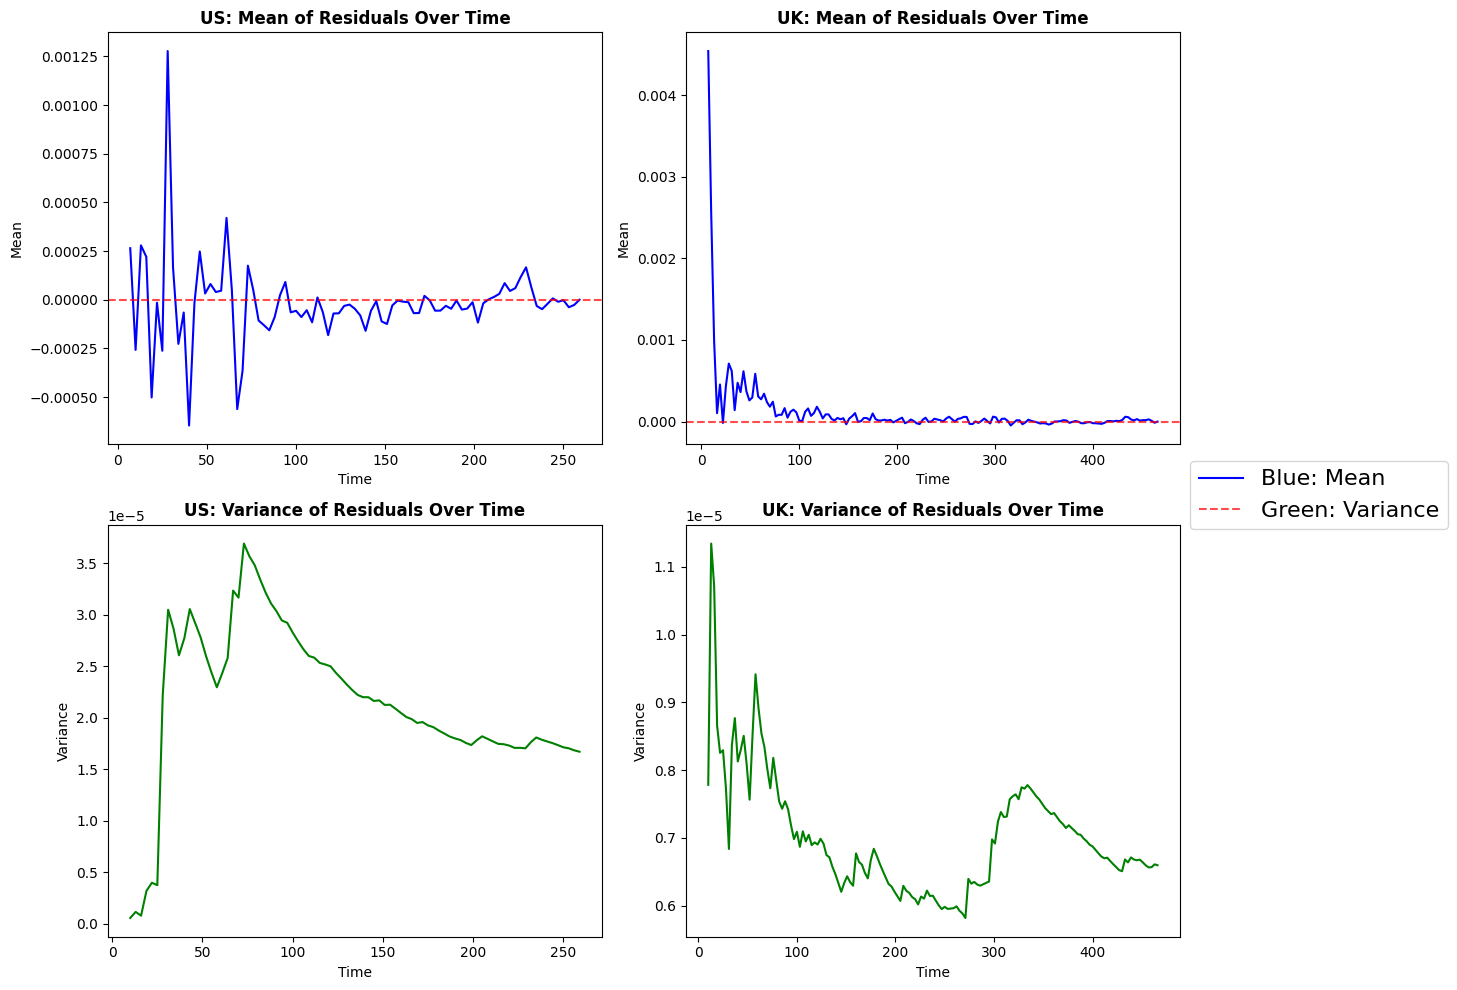

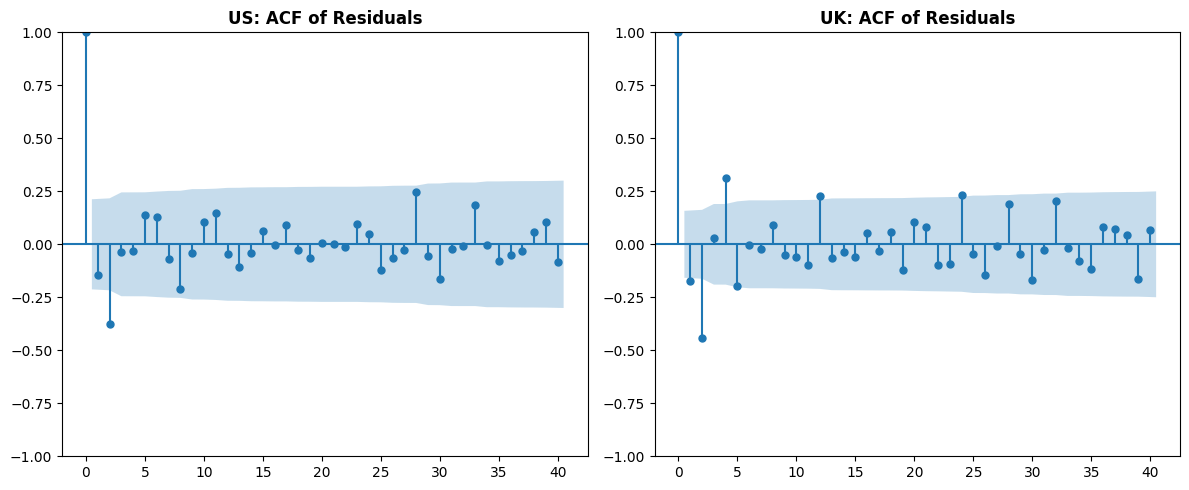

In [5]:
# Define function to fit AR(1) model and compute residuals
def fit_ar1(df, country):
    df_ar1 = df.copy()
    df_ar1['infl_rate_diff_lag1'] = df_ar1['infl_rate_diff'].shift(1)
    df_ar1 = df_ar1.dropna(subset=['infl_rate_diff', 'infl_rate_diff_lag1'])
    
    X = df_ar1['infl_rate_diff_lag1']
    y = df_ar1['infl_rate_diff']
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    residuals = model.resid
    
    mean_residuals = residuals.expanding().mean()
    var_residuals = residuals.expanding().var()
    
    return model, residuals, mean_residuals, var_residuals

# Fit AR(1) model and get residuals for UK and US
model_uk, residuals_uk, mean_resid_uk, var_resid_uk = fit_ar1(df_uk, 'UK')
model_us, residuals_us, mean_resid_us, var_resid_us = fit_ar1(df_us, 'US')

# Plot mean and variance of residuals (2x2)
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# US Mean of Residuals
ax[0, 0].plot(mean_resid_us, label='US Mean Residuals', color='blue')
ax[0, 0].axhline(0, color='red', linestyle='--', alpha=0.7)
ax[0, 0].set_title('US: Mean of Residuals Over Time', fontweight = 'bold')
ax[0, 0].set_xlabel('Time')
ax[0, 0].set_ylabel('Mean')
# ax[0, 0].legend()
# ax[0, 0].grid(alpha=0.5)

# US Variance of Residuals
ax[1, 0].plot(var_resid_us, label='US Variance Residuals', color='green')
ax[1, 0].set_title('US: Variance of Residuals Over Time', fontweight = 'bold')
ax[1, 0].set_xlabel('Time')
ax[1, 0].set_ylabel('Variance')
# ax[1, 0].legend()
# ax[0, 1].grid(alpha=0.5)

# UK Mean of Residuals
ax[0, 1].plot(mean_resid_uk, label='UK Mean Residuals', color='blue')
ax[0, 1].axhline(0, color='red', linestyle='--', alpha=0.7)
ax[0, 1].set_title('UK: Mean of Residuals Over Time', fontweight = 'bold')
ax[0, 1].set_xlabel('Time')
ax[0, 1].set_ylabel('Mean')
# ax[0, 1].legend()
# ax[1, 0].grid(alpha=0.5)

# UK Variance of Residuals
ax[1, 1].plot(var_resid_uk, label='UK Variance Residuals', color='green')
ax[1, 1].set_title('UK: Variance of Residuals Over Time', fontweight = 'bold')
ax[1, 1].set_xlabel('Time')
ax[1, 1].set_ylabel('Variance')
# ax[1, 1].legend()
# ax[1, 1].grid(alpha=0.5)# Common Legend
fig.legend(['Blue: Mean', 'Green: Variance'], loc='center right', ncol=1, bbox_to_anchor=(1.22, 0.5), fontsize = 16)

plt.tight_layout()
plt.show()

# Plot ACF of residuals (1x2)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sm.graphics.tsa.plot_acf(residuals_us, lags=40, ax=ax[0])
ax[0].set_title("US: ACF of Residuals", fontweight = 'bold')

sm.graphics.tsa.plot_acf(residuals_uk, lags=40, ax=ax[1])
ax[1].set_title("UK: ACF of Residuals", fontweight = 'bold')

plt.tight_layout()
plt.show()

## UK

In [6]:
# df_uk_ar1 = df_uk.copy()

# # Create lagged variable for infl_rate_diff
# df_uk_ar1['infl_rate_diff_lag1'] = df_uk_ar1['infl_rate_diff'].shift(1)

# # Drop rows with NaN values due to lagging
# df_uk_ar1 = df_uk_ar1.dropna(subset=['infl_rate_diff', 'infl_rate_diff_lag1'])

# # Define dependent and independent variables
# X = df_uk_ar1['infl_rate_diff_lag1']
# y = df_uk_ar1['infl_rate_diff']

# # Add constant to the independent variable
# X = sm.add_constant(X)

# # Fit the OLS model
# model = sm.OLS(y, X).fit()

# # Print the summary of the regression
# print(model.summary())

# # Generate residuals
# residuals = model.resid

# # Compute moments (mean and variance) of residuals over time
# mean_residuals = residuals.expanding().mean()
# var_residuals = residuals.expanding().var()

# # Plot the moments of residuals
# fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# # Plot mean of residuals
# ax[0].plot(mean_residuals, label='Mean of Residuals', color='blue')
# ax[0].axhline(0, color='red', linestyle='--', alpha=0.7)
# ax[0].set_title('Mean of Residuals Over Time')
# ax[0].set_xlabel('Time')
# ax[0].set_ylabel('Mean')
# ax[0].legend()
# ax[0].grid(alpha=0.5)

# # Plot variance of residuals
# ax[1].plot(var_residuals, label='Variance of Residuals', color='green')
# ax[1].set_title('Variance of Residuals Over Time')
# ax[1].set_xlabel('Time')
# ax[1].set_ylabel('Variance')
# ax[1].legend()
# ax[1].grid(alpha=0.5)

# plt.tight_layout()
# plt.show()

# # Plot ACF of residuals
# sm.graphics.tsa.plot_acf(residuals, lags=40)
# plt.show()

## US

In [7]:
# df_us_ar1 = df_us.copy()

# # Create lagged variable for infl_rate_diff
# df_us_ar1['infl_rate_diff_lag1'] = df_us_ar1['infl_rate_diff'].shift(1)

# # Drop rows with NaN values due to lagging
# df_us_ar1 = df_us_ar1.dropna(subset=['infl_rate_diff', 'infl_rate_diff_lag1'])

# # Define dependent and independent variables
# X = df_us_ar1['infl_rate_diff_lag1']
# y = df_us_ar1['infl_rate_diff']

# # Add constant to the independent variable
# X = sm.add_constant(X)

# # Fit the OLS model
# model = sm.OLS(y, X).fit()

# # Print the summary of the regression
# print(model.summary())

# # Generate residuals
# residuals = model.resid

# # Compute moments (mean and variance) of residuals over time
# mean_residuals = residuals.expanding().mean()
# var_residuals = residuals.expanding().var()

# # Plot the moments of residuals
# fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# # Plot mean of residuals
# ax[0].plot(mean_residuals, label='Mean of Residuals', color='blue')
# ax[0].axhline(0, color='red', linestyle='--', alpha=0.7)
# ax[0].set_title('Mean of Residuals Over Time')
# ax[0].set_xlabel('Time')
# ax[0].set_ylabel('Mean')
# ax[0].legend()
# ax[0].grid(alpha=0.5)

# # Plot variance of residuals
# ax[1].plot(var_residuals, label='Variance of Residuals', color='green')
# ax[1].set_title('Variance of Residuals Over Time')
# ax[1].set_xlabel('Time')
# ax[1].set_ylabel('Variance')
# ax[1].legend()
# ax[1].grid(alpha=0.5)

# plt.tight_layout()
# plt.show()

# # Plot ACF of residuals
# sm.graphics.tsa.plot_acf(residuals, lags=40)
# plt.show()

## Is R² estimate relevant?

R² is designed for models with independent and identically distributed (IID) residuals. In AR(1) models, the errors are autocorrelated as seen by significant spikes in the ACF plots of the residuals (as seen below in Figure 2). This means each error term depends on previous values, violating the IID assumption. This can make R² misleading because a high R² doesn’t necessarily mean a good predictive fit in the presence of autocorrelation. This same rationale holds true for AR(p) in Figure 3 and ADL models. As such, we did not use R² for the determination of the optimal lag.

## Analysing moments

To further confirm stationarity for the differenced inflation, we plotted the residuals and variance against time. For a well-specified model, the mean of residuals should hover around 0 without significant deviations over time. Significant deviations from 0 suggests that the model has a bias or is missing some key explanatory variables. Apart from the mean, homoscedasticity should be observed, where the variance of the residuals should remain relatively constant over time. Volatilities of the residuals indicate heteroscedasticity, which violates one of the key assumptions of OLS regression. As shown by Figure 4, it can be seen that the mean for both US and UK hovers around 0, and the variance also stabilise over time. Therefore, this indicates stationarity in both the US and UK’s differenced inflation variable, thereby allowing it to be suitably forecasted by the various models.

# `p`-Order Autoregressive Model

## How to determine lag order `p`?

Given the differing natures of the US and UK economies, they are likely to be affected by their historical values to different extents. Therefore, to determine the optimal lag p for subsequent use in the AR(p) model, the use of Partial Autocorrelation Function (PACF) plots aids in illustrating the reliance of individual factors to their historical values. As shown by Figure 1, the reliance of US’s differenced inflation to its historical values remains relatively high until lag 14 where it is out of the significance band, hence the null hypothesis that lag-14 is not statistically significant should be rejected. This is smaller than that of the UK which is observed to have a reliance until its 35th lag.

## UK

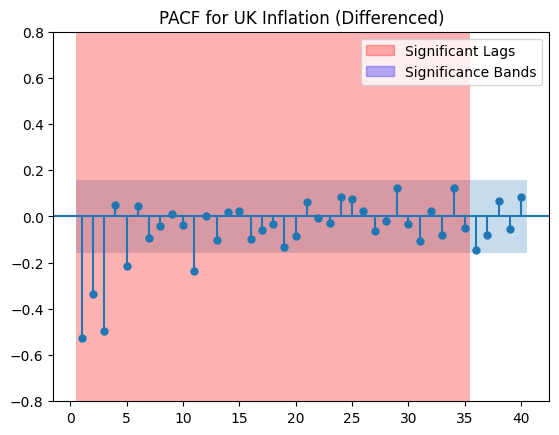

Lag with the lowest AIC: 3


In [8]:
df_uk_arp = df_uk.copy()

fig, ax = plt.subplots()
sm.graphics.tsa.plot_pacf(df_uk_arp['infl_rate_diff'], lags=40, zero=False, title = "PACF for UK Inflation (Differenced)", ax=ax)

# Add a shaded rectangle for lags <= 35
rectangle = patches.Rectangle((0.5, -1), 35, 2, linewidth=0, edgecolor='none', facecolor='red', alpha=0.3)
ax.add_patch(rectangle)
red_patch = patches.Patch(color='red', alpha=0.3, label='Significant Lags')
blue_patch = patches.Patch(color='blue', alpha=0.3, label='Significance Bands')

# Add the legend to the plot
ax.legend(handles=[red_patch, blue_patch], loc='upper right')
plt.ylim(-0.8, 0.8)
plt.show()  # 35 lags

# Create a DataFrame to store AIC, BIC, and R² for AR(p) models
uk_ar_metrics = {}

# Loop through lag values from 1 to 40
for p in range(1, 41):
    # Create lagged variables up to lag p
    lagged_data = pd.concat([df_uk_arp['infl_rate_diff'].shift(i) for i in range(1, p + 1)], axis=1)
    lagged_data.columns = [f'infl_rate_diff_lag{i}' for i in range(1, p + 1)]
    
    # Combine lagged variables with the dependent variable
    data = pd.concat([df_uk_arp['infl_rate_diff'], lagged_data], axis=1).dropna()  # Drop rows with NaN values
    
    # Define dependent and independent variables
    y = data['infl_rate_diff']
    X = data.drop(columns=['infl_rate_diff'])
    X = sm.add_constant(X)  # Add constant to the independent variables
    
    # Fit the AR(p) model
    model = sm.OLS(y, X).fit()
    
    # Store AIC, BIC, and R² for the model
    uk_ar_metrics[p] = {
        'AIC': round(model.aic, 2),
        'BIC': round(model.bic, 2),
        'R2': round(model.rsquared, 4),
        'Adj R2': round(model.rsquared_adj, 4)
    }

# Convert the metrics dictionary to a DataFrame for easier analysis
uk_arp_metrics_df = pd.DataFrame.from_dict(uk_ar_metrics, orient='index')
uk_arp_metrics_df.index.name = 'Lag'
uk_arp_metrics_df.reset_index(inplace=True)

# Save best lag based on AIC
uk_arp_lag = uk_arp_metrics_df[uk_arp_metrics_df["AIC"] == uk_arp_metrics_df["AIC"].min()]["Lag"].values[0]
print(f'Lag with the lowest AIC: {uk_arp_lag}')

# Display the metrics
# uk_arp_metrics_df

## US

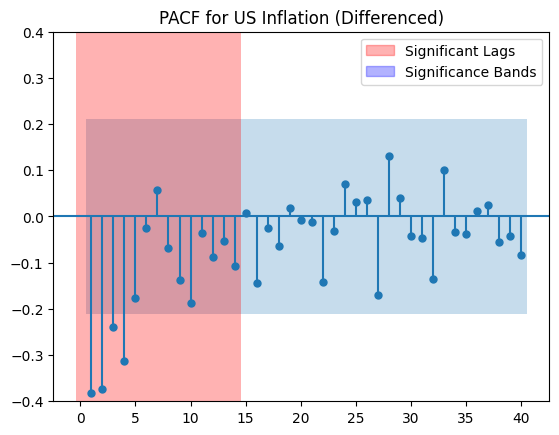

Lag with the lowest BIC: 2


In [9]:
df_us_arp = df_us.copy()

fig, ax = plt.subplots()
sm.graphics.tsa.plot_pacf(df_us_arp['infl_rate_diff'], lags=40, zero=False, title = "PACF for US Inflation (Differenced)", ax=ax)

# Add a shaded rectangle for lags <= 14
rectangle = patches.Rectangle((-0.4, -0.4), 15, 0.8, linewidth=0, edgecolor='none', facecolor='red', alpha=0.3)
ax.add_patch(rectangle)
red_patch = patches.Patch(color='red', alpha=0.3, label='Significant Lags')
blue_patch = patches.Patch(color='blue', alpha=0.3, label='Significance Bands')

# Add the legend to the plot
ax.legend(handles=[red_patch, blue_patch], loc='upper right')
plt.ylim(-0.4, 0.4)
plt.show()  # 14 lags

# Create a DataFrame to store AIC, BIC, and R² for AR(p) models
us_ar_metrics = {}

# Loop through lag values from 1 to 40
for p in range(1, 41):
    # Create lagged variables up to lag p
    lagged_data = pd.concat([df_us_arp['infl_rate_diff'].shift(i) for i in range(1, p + 1)], axis=1)
    lagged_data.columns = [f'infl_rate_diff_lag{i}' for i in range(1, p + 1)]
    
    # Combine lagged variables with the dependent variable
    data = pd.concat([df_us_arp['infl_rate_diff'], lagged_data], axis=1).dropna()  # Drop rows with NaN values
    
    # Define dependent and independent variables
    y = data['infl_rate_diff']
    X = data.drop(columns=['infl_rate_diff'])
    X = sm.add_constant(X)  # Add constant to the independent variables
    
    # Fit the AR(p) model
    model = sm.OLS(y, X).fit()
    
    # Store AIC, BIC, and R² for the model
    us_ar_metrics[p] = {
        'AIC': round(model.aic, 2),
        'BIC': round(model.bic, 2),
        'R2': round(model.rsquared, 4),
        'Adj R2': round(model.rsquared_adj, 4)
    }

# Convert the metrics dictionary to a DataFrame for easier analysis
us_arp_metrics_df = pd.DataFrame.from_dict(us_ar_metrics, orient='index')
us_arp_metrics_df.index.name = 'Lag'
us_arp_metrics_df.reset_index(inplace=True)

# Save best lag based on AIC
us_arp_lag = us_arp_metrics_df[us_arp_metrics_df["AIC"] == us_arp_metrics_df["AIC"].min()]["Lag"].values[0]
print(f'Lag with the lowest BIC: {us_arp_lag}')

# Display the metrics
# us_arp_metrics_df

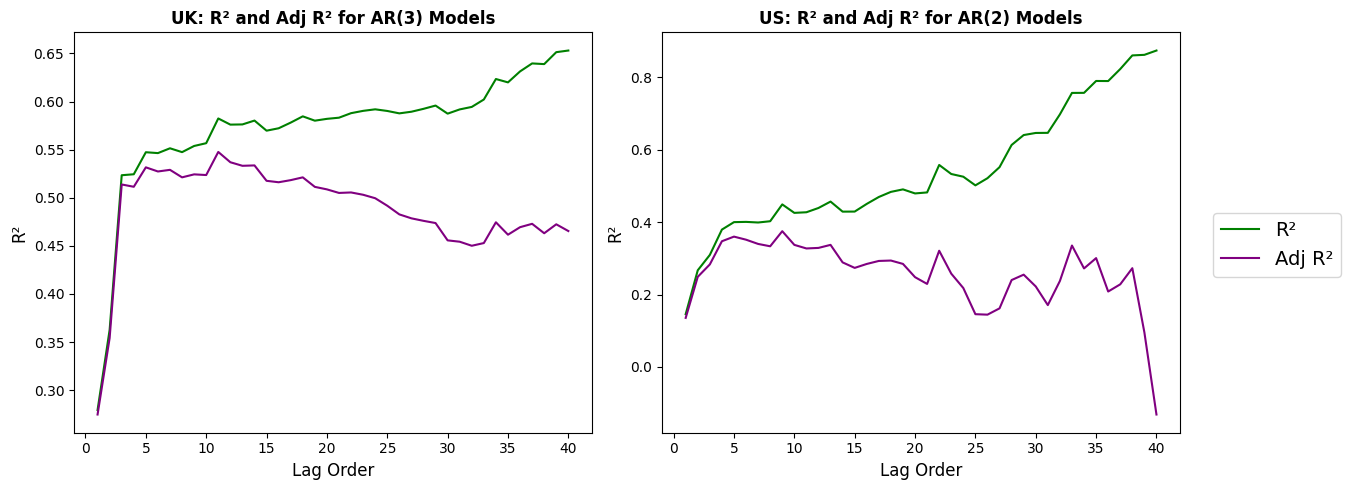

In [21]:
# Plot AIC and BIC values together
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(uk_arp_metrics_df['Lag'], uk_arp_metrics_df['AIC'], label='AIC', color='blue')
# ax.plot(uk_arp_metrics_df['Lag'], uk_arp_metrics_df['BIC'], label='BIC', color='red')
# ax.set_title('AIC and BIC for AR(p) Models')
# ax.set_xlabel('Lag Order')
# ax.set_ylabel('Value')
# ax.legend()
# ax.grid(alpha=0.5)
# plt.show()

# Plot R² and Adjusted R² values together
# plt.figure(figsize=(10, 5))
# plt.plot(uk_arp_metrics_df['Lag'], uk_arp_metrics_df['R2'], label='R²', color='green')
# plt.plot(uk_arp_metrics_df['Lag'], uk_arp_metrics_df['Adj R2'], label='Adj R²', color='purple')
# plt.title('R² and Adj R² for AR(p) Models')
# plt.xlabel('Lag Order')
# plt.ylabel('R²')
# plt.legend()
# plt.grid(alpha=0.5)
# plt.show()

# plt.figure(figsize=(10, 5))
# plt.plot(us_arp_metrics_df['Lag'], us_arp_metrics_df['R2'], label='R²', color='green')
# plt.plot(us_arp_metrics_df['Lag'], us_arp_metrics_df['Adj R2'], label='Adj R²', color='purple')
# plt.title('R² and Adj R² for AR(p) Models')
# plt.xlabel('Lag Order')
# plt.ylabel('R²')
# plt.legend()
# plt.grid(alpha=0.5)
# plt.show()

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# UK Plot
ax[0].plot(uk_arp_metrics_df['Lag'], uk_arp_metrics_df['R2'], label='R²', color='green')
ax[0].plot(uk_arp_metrics_df['Lag'], uk_arp_metrics_df['Adj R2'], label='Adj R²', color='purple')
ax[0].set_title(f'UK: R² and Adj R² for AR({uk_arp_lag}) Models', fontweight='bold')
ax[0].set_xlabel('Lag Order', fontsize = 12)
ax[0].set_ylabel('R²', fontsize = 12)

# US Plot
ax[1].plot(us_arp_metrics_df['Lag'], us_arp_metrics_df['R2'], label='R²', color='green')
ax[1].plot(us_arp_metrics_df['Lag'], us_arp_metrics_df['Adj R2'], label='Adj R²', color='purple')
ax[1].set_title(f'US: R² and Adj R² for AR({us_arp_lag}) Models', fontweight='bold')
ax[1].set_xlabel('Lag Order', fontsize = 12)
ax[1].set_ylabel('R²', fontsize = 12)

# Common Legend
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', ncol=1, bbox_to_anchor=(1.13,0.5), fontsize = 14)

plt.tight_layout()
plt.show()

In [22]:
# # Plot AIC and BIC values together
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(us_arp_metrics_df['Lag'], us_arp_metrics_df['AIC'], label='AIC', color='blue')
# ax.plot(us_arp_metrics_df['Lag'], us_arp_metrics_df['BIC'], label='BIC', color='red')
# ax.set_title('AIC and BIC for AR(p) Models')
# ax.set_xlabel('Lag Order')
# ax.set_ylabel('Value')
# ax.legend()
# ax.grid(alpha=0.5)
# plt.show()

# Plot R² and Adjusted R² values together
# plt.figure(figsize=(10, 5))
# plt.plot(us_arp_metrics_df['Lag'], us_arp_metrics_df['R2'], label='R²', color='green')
# plt.plot(us_arp_metrics_df['Lag'], us_arp_metrics_df['Adj R2'], label='Adj R²', color='purple')
# plt.title('R² and Adj R² for AR(p) Models')
# plt.xlabel('Lag Order')
# plt.ylabel('R²')
# plt.legend()
# plt.grid(alpha=0.5)
# plt.show()

## Did you obtain a higher R² with the additional lags?

**UK**
- Baseline: AR(1) R² = 0.2794 (0.2747)
- PACF: AR(35) R² = 0.6199 (0.4616)
- AIC: AR(3) R² = 0.5234 (0.5138)

**US**
- Baseline: AR(1) R² = 0.146 (0.1357)
- PACF: AR(14) R² = 0.4292 (0.289)
- AIC: AR(2) R² = 0.2672 (0.2491)

Using AIC & BIC to select AR(`p`) seems to achieve much higher R² than AR(1).

Using PACF achieves even higher R². However, R² as a metric can only increase as you add more lags.

Adjusted R² is plotted alongside to penalise the model for more lags being added.

# Autoregressive Distributed Lag (ADL) Model

## How should you determine the orders `p` and `q`?

1. **Information Criteria:**
    - Use Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC).
    - Fit ADL models with different combinations of `p` (lags of the dependent variable) and `q` (lags of the independent variable).
    - Select the model with the lowest AIC or BIC value.

2. **Partial Autocorrelation Function (PACF):**
    - Use the PACF plot of the dependent variable to determine the appropriate lag order `p`.
    - The lag at which the PACF cuts off (becomes insignificant) is a good candidate for `p`.
    - Already done as seen above.
    - Does not help determine order `q`.

3. **Residual Diagnostics:**
    - Check the residuals of the fitted model for autocorrelation and stationarity.
    - Adjust `p` and `q` to ensure that the residuals meet the assumptions of the model.

## UK

In [23]:
# Define the range of lags for p (infl_rate_diff lags) and q (independent variable lags)
# max_p = 5  # Maximum number of lags for infl_rate_diff
max_q = 20  # Maximum number of lags for independent variables

# List of independent variables to loop through
independent_vars = ['ppi_diff', 'gdp_pct_change', 'int_3m', 'cons_conf', 'unm_rate']

# Create a dictionary to store the results
results = []

# Loop through each independent variable
for var in independent_vars:
    # Loop through all combinations of p and q
    # for p in range(1, max_p + 1):  # Loop over lags for infl_rate_diff
    for p in [1, 35, 3]:  # Loop over p lags for infl_rate_diff as determined previously
        for q in range(0, max_q + 1):  # Loop over lags for the current independent variable
            # Create lagged variables for infl_rate_diff
            df_uk_adl = df_uk.copy()
            for lag in range(1, p + 1):
                df_uk_adl[f'infl_rate_diff_lag{lag}'] = df_uk_adl['infl_rate_diff'].shift(lag)
            
            # Create lagged variables for the current independent variable
            for lag in range(1, q + 1):
                df_uk_adl[f'{var}_lag{lag}'] = df_uk_adl[var].shift(lag)
            
            # Drop rows with NaN values due to lagging
            df_uk_adl = df_uk_adl.dropna()
            
            # Define dependent and independent variables
            y = df_uk_adl['infl_rate_diff']
            X = df_uk_adl.drop(columns=['infl_rate_diff', 'ppi_diff', 'gdp_pct_change', 'int_3m', 'cons_conf', 'unm_rate', 'date'])  # Drop original columns and non-numeric columns
            X = sm.add_constant(X)  # Add a constant to the independent variables
            
            # Fit the ADL model
            model = sm.OLS(y, X).fit()
            
            # Store the results
            results.append({
                'Variable': var,
                'p': p,
                'q': q,
                'AIC': round(model.aic, 2),
                'BIC': round(model.bic, 2),
                'R2': round(model.rsquared, 4),
                'Adj R2': round(model.rsquared_adj, 4)
            })

# Convert the results to a DataFrame for easier analysis
uk_adl_metrics = pd.DataFrame(results)

# Get row with lowest AIC & BIC for each variable
print('Lowest AIC for each variable:')
uk_adl_best_bic = uk_adl_metrics.loc[uk_adl_metrics.groupby('Variable')['AIC'].idxmin()]
# print('\nLowest BIC for each variable:')
# uk_adl_best_bic = uk_adl_metrics.loc[uk_adl_metrics.groupby('Variable')['BIC'].idxmin()]
print(uk_adl_best_bic)

# Display the results
uk_adl_metrics

Lowest AIC for each variable:
           Variable   p   q      AIC      BIC      R2  Adj R2
232       cons_conf   3   1 -1618.01 -1599.87  0.8570  0.8521
108  gdp_pct_change   3   3 -1627.20 -1603.01  0.8689  0.8625
169          int_3m   3   1 -1637.06 -1618.92  0.8738  0.8695
46         ppi_diff   3   4 -1677.66 -1650.51  0.9143  0.9094
293        unm_rate  35  20 -1621.07 -1462.18  0.9961  0.9927


Variable  p   q      AIC      BIC      R2  Adj R2
0    ppi_diff  1   0 -1544.94 -1535.83  0.7277  0.7241
1    ppi_diff  1   1 -1587.86 -1575.71  0.7966  0.7925
2    ppi_diff  1   2 -1586.36 -1571.20  0.8082  0.8030
3    ppi_diff  1   3 -1574.77 -1556.62  0.8099  0.8034
4    ppi_diff  1   4 -1576.33 -1555.21  0.8278  0.8206
..        ... ..  ..      ...      ...     ...     ...
310  unm_rate  3  16 -1452.45 -1390.82  0.8512  0.8259
311  unm_rate  3  17 -1439.83 -1375.43  0.8524  0.8257
312  unm_rate  3  18 -1426.50 -1359.34  0.8491  0.8200
313  unm_rate  3  19 -1416.00 -1346.09  0.8457  0.8140
314  unm_rate  3  20 -1404.76 -1332.12  0.8468  0.8134

[315 rows x 7 columns]

## US

In [24]:
# Define the range of lags for p (infl_rate_diff lags) and q (independent variable lags)
# max_p = 5  # Maximum number of lags for infl_rate_diff
max_q = 20  # Maximum number of lags for independent variables

# List of independent variables to loop through
independent_vars = ['ppi_diff', 'gdp_pct_change', 'int_3m', 'cons_conf', 'unm_rate']

# Create a dictionary to store the results
results = []

# Loop through each independent variable
for var in independent_vars:
    # Loop through all combinations of p and q
    # for p in range(1, max_p + 1):  # Loop over lags for infl_rate_diff
    for p in [1, 14, 2]:  # Loop over p lags for infl_rate_diff as determined previously
        for q in range(0, max_q + 1):  # Loop over lags for the current independent variable
            # Create lagged variables for infl_rate_diff
            df_us_adl = df_us.copy()
            for lag in range(1, p + 1):
                df_us_adl[f'infl_rate_diff_lag{lag}'] = df_us_adl['infl_rate_diff'].shift(lag)
            
            # Create lagged variables for the current independent variable
            for lag in range(1, q + 1):
                df_us_adl[f'{var}_lag{lag}'] = df_us_adl[var].shift(lag)
            
            # Drop rows with NaN values due to lagging
            df_us_adl = df_us_adl.dropna()
            
            # Define dependent and independent variables
            y = df_us_adl['infl_rate_diff']
            X = df_us_adl.drop(columns=['infl_rate_diff', 'ppi_diff', 'gdp_pct_change', 'int_3m', 'cons_conf', 'unm_rate', 'date'])  # Drop original columns and non-numeric columns
            X = sm.add_constant(X)  # Add a constant to the independent variables
            
            # Fit the ADL model
            model = sm.OLS(y, X).fit()
            
            # Store the results
            results.append({
                'Variable': var,
                'p': p,
                'q': q,
                'AIC': round(model.aic, 2),
                'BIC': round(model.bic, 2),
                'R2': round(model.rsquared, 4),
                'Adj R2': round(model.rsquared_adj, 4)
            })

# Convert the results to a DataFrame for easier analysis
us_adl_metrics = pd.DataFrame(results)

# Get row with lowest AIC & BIC for each variable
print('Lowest AIC for each variable:')
us_adl_best_bic = us_adl_metrics.loc[us_adl_metrics.groupby('Variable')['AIC'].idxmin()]
# print('\nLowest BIC for each variable:')
# us_adl_best_bic = us_adl_metrics.loc[us_adl_metrics.groupby('Variable')['BIC'].idxmin()]
print(us_adl_best_bic)

# Display the results
us_adl_metrics

Lowest AIC for each variable:
           Variable   p   q     AIC     BIC      R2  Adj R2
233       cons_conf   2   2 -797.98 -783.39  0.8055  0.7931
107  gdp_pct_change   2   2 -803.76 -789.18  0.8185  0.8069
160          int_3m  14  13 -805.08 -739.05  0.9756  0.9597
45         ppi_diff   2   3 -850.35 -833.42  0.9111  0.9041
295        unm_rate   2   1 -792.69 -780.54  0.7879  0.7772


Variable  p   q     AIC     BIC      R2  Adj R2
0    ppi_diff  1   0 -766.37 -759.04  0.6570  0.6486
1    ppi_diff  1   1 -808.58 -798.81  0.7961  0.7886
2    ppi_diff  1   2 -827.62 -815.46  0.8601  0.8530
3    ppi_diff  1   3 -817.48 -802.97  0.8647  0.8560
4    ppi_diff  1   4 -805.39 -788.54  0.8660  0.8553
..        ... ..  ..     ...     ...     ...     ...
310  unm_rate  2  16 -671.97 -627.00  0.8530  0.7971
311  unm_rate  2  17 -664.87 -617.95  0.8649  0.8086
312  unm_rate  2  18 -654.30 -605.47  0.8699  0.8105
313  unm_rate  2  19 -641.85 -591.14  0.8714  0.8071
314  unm_rate  2  20 -630.30 -577.75  0.8687  0.7968

[315 rows x 7 columns]

## Did you obtain a higher R² with the additional lags?

Yes R² is always higher with additional lags for `p`.

Additional lags of `q` also achieves higher R², though often 1 lag of `q` is sufficient.

# Pseudo Out-of-Sample Forecast

## UK

### AR(1)

In [25]:
# Create lagged variables for the regression
df_uk_ar1_rolling = df_uk.copy()
df_uk_ar1_rolling['infl_rate_diff_lag1'] = df_uk_ar1_rolling['infl_rate_diff'].shift(1)  # Lagged dependent variable

# Drop rows with NaN values due to lagging
df_uk_ar1_rolling = df_uk_ar1_rolling.dropna()

# Initialize variables for rolling window forecasting
results = []  # To store results as a list of dictionaries
rolling_window_size = 30  # Set the rolling window size to 30

# Ensure there are enough observations for the rolling window
if len(df_uk_ar1_rolling) < rolling_window_size:
    raise ValueError("Not enough data for the specified rolling window size.")

# Start with the first rolling window
for i in range(rolling_window_size, len(df_uk_ar1_rolling)):
    # Define the rolling window
    X_rolling = df_uk_ar1_rolling.iloc[i - rolling_window_size:i][['infl_rate_diff_lag1']]  # Independent variables
    y_rolling = df_uk_ar1_rolling.iloc[i - rolling_window_size:i]['infl_rate_diff']  # Dependent variable
    
    # Add a constant to the independent variables
    X_rolling = sm.add_constant(X_rolling)
    
    # Fit the model on the rolling window
    rolling_model = sm.OLS(y_rolling, X_rolling).fit()
    
    # Use the current observation for prediction
    current_row = df_uk_ar1_rolling.iloc[i][['infl_rate_diff_lag1']]
    current_row = pd.DataFrame([current_row])  # Convert to DataFrame to match shape
    current_row = sm.add_constant(current_row, has_constant='add')  # Add a constant to match the model
    
    # Predict infl_rate_diff
    forecast_diff = rolling_model.predict(current_row)  # Predict infl_rate_diff
    
    # Compute infl_rate_T = infl_rate_diff_T + infl_rate_T-1
    last_infl_rate = df_uk_ar1_rolling.iloc[i - 1]['infl_rate']  # infl_rate at T-1
    forecast_infl_rate = forecast_diff.iloc[0] + last_infl_rate
    
    # Calculate the standard error of the forecast
    se = np.sqrt(rolling_model.mse_resid)  # Standard error of residuals
    z = st.norm.ppf(0.975)  # Critical value for 95% confidence interval
    lower_bound = forecast_infl_rate - z * se
    upper_bound = forecast_infl_rate + z * se
    
    # Store the results in a dictionary
    results.append({
        'Date': df_uk_ar1_rolling.iloc[i]['date'],
        'Forecast_infl_rate': forecast_infl_rate,
        'Actual_infl_rate': df_uk_ar1_rolling.iloc[i]['infl_rate'],
        'Lower_95_FI': lower_bound,
        'Upper_95_FI': upper_bound
    })

# Convert results to a pandas DataFrame
uk_ar1_forecast_results = pd.DataFrame(results)

# Calculate RMSE for infl_rate
rmse_infl_rate = np.sqrt(mean_squared_error(uk_ar1_forecast_results['Actual_infl_rate'], uk_ar1_forecast_results['Forecast_infl_rate']))
print(f"Root Mean Squared Error (RMSE) for infl_rate: {rmse_infl_rate:.4f}")

# Within 95% forecast interval
uk_ar1_forecast_results['Within_95_FI'] = (uk_ar1_forecast_results['Actual_infl_rate'] >= uk_ar1_forecast_results['Lower_95_FI']) & (uk_ar1_forecast_results['Actual_infl_rate'] <= uk_ar1_forecast_results['Upper_95_FI'])

# Display uk_ar1_forecast_results
uk_ar1_forecast_results

Root Mean Squared Error (RMSE) for infl_rate: 0.0026


Date  Forecast_infl_rate  Actual_infl_rate  Lower_95_FI  \
0   1994-03-01            0.004504          0.003115    -0.000588   
1   1994-06-01            0.003139          0.000000    -0.001727   
2   1994-09-01            0.002185          0.001536    -0.002769   
3   1994-12-01            0.000282          0.004601    -0.004592   
4   1995-03-01            0.002453          0.004566    -0.002557   
..         ...                 ...               ...          ...   
119 2023-12-01            0.004707          0.003846     0.000908   
120 2024-03-01            0.004353          0.006116     0.000547   
121 2024-06-01            0.005582          0.002261     0.001729   
122 2024-09-01            0.003627          0.000750    -0.000375   
123 2024-12-01            0.001072          0.003715    -0.003043   

     Upper_95_FI  Within_95_FI  
0       0.009595          True  
1       0.008005          True  
2       0.007139          True  
3       0.005156          True  
4       0.007463          True  
..           ...           ...  
119     0.008506          True  
120     0.008158          True  
121     0.009435          True  
122     0.007629          True  
123     0.005187          True  

[124 rows x 6 columns]

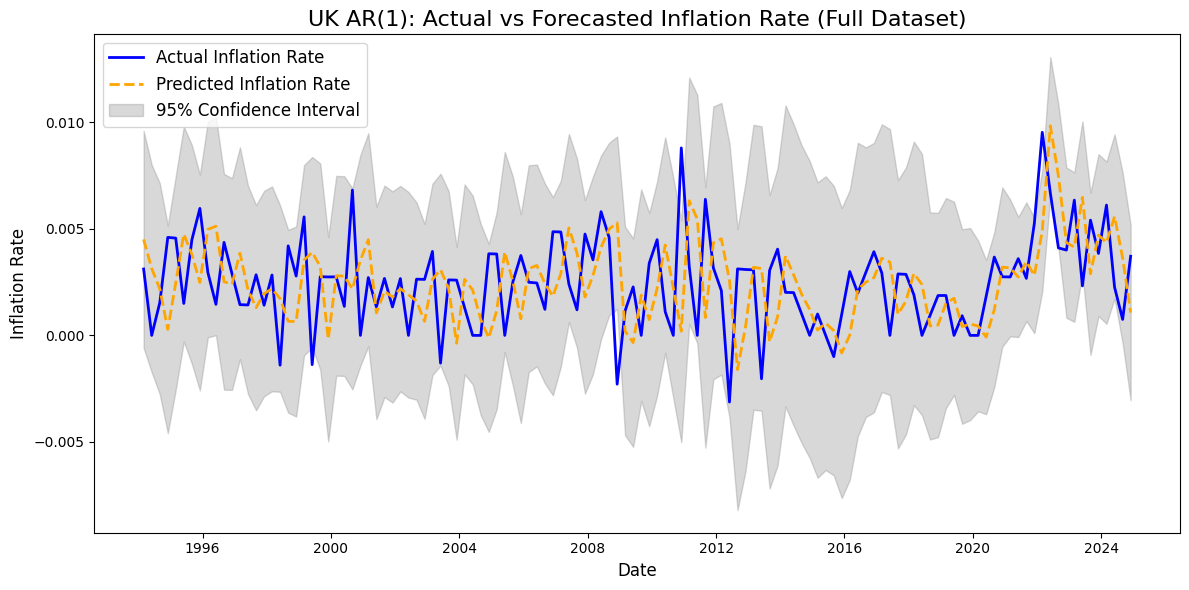

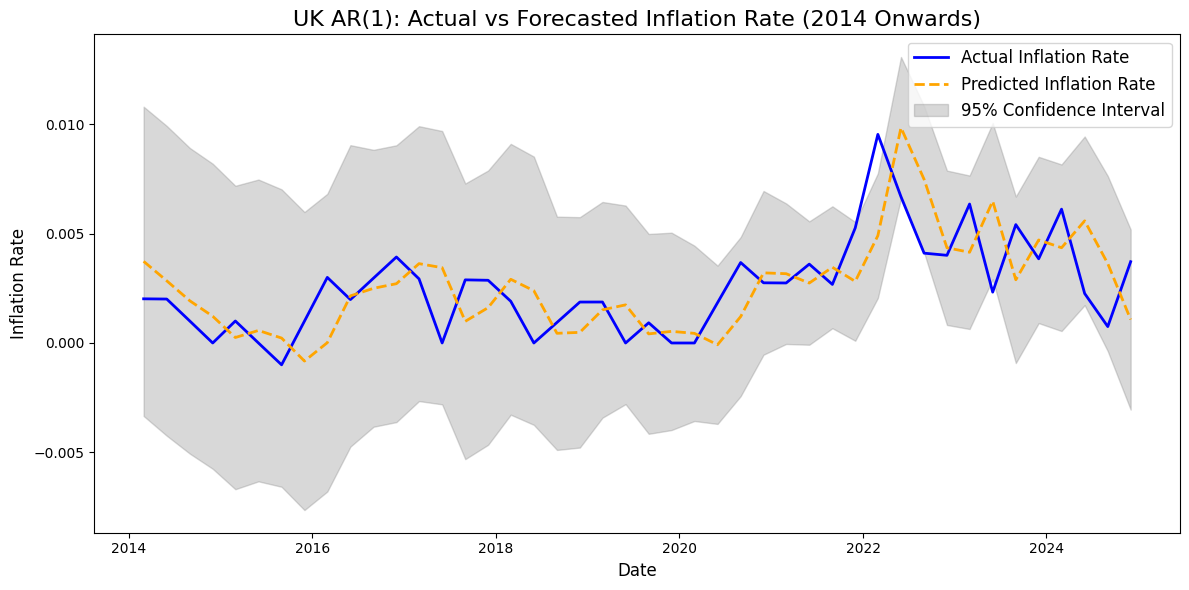

In [26]:
# Ensure the 'Date' column is in datetime format
uk_ar1_forecast_results['Date'] = pd.to_datetime(uk_ar1_forecast_results['Date'])

# Original plot (entire dataset)
plt.figure(figsize=(12, 6))
plt.plot(uk_ar1_forecast_results['Date'], uk_ar1_forecast_results['Actual_infl_rate'], label='Actual Inflation Rate', color='blue', linewidth=2)
plt.plot(uk_ar1_forecast_results['Date'], uk_ar1_forecast_results['Forecast_infl_rate'], label='Predicted Inflation Rate', color='orange', linestyle='--', linewidth=2)

# Add 95% confidence intervals
plt.fill_between(uk_ar1_forecast_results['Date'], 
                 uk_ar1_forecast_results['Lower_95_FI'], 
                 uk_ar1_forecast_results['Upper_95_FI'], 
                 color='gray', alpha=0.3, label='95% Confidence Interval')

# Format x-axis ticks
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add labels, title, and legend
plt.title('UK AR(1): Actual vs Forecasted Inflation Rate (Full Dataset)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Inflation Rate', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the original plot
plt.show()





# Filter data from 2014 onwards
uk_ar1_forecast_results_2014 = uk_ar1_forecast_results[uk_ar1_forecast_results['Date'] >= '2014-01-01']

# Plot for data from 2014 onwards
plt.figure(figsize=(12, 6))
plt.plot(uk_ar1_forecast_results_2014['Date'], uk_ar1_forecast_results_2014['Actual_infl_rate'], label='Actual Inflation Rate', color='blue', linewidth=2)
plt.plot(uk_ar1_forecast_results_2014['Date'], uk_ar1_forecast_results_2014['Forecast_infl_rate'], label='Predicted Inflation Rate', color='orange', linestyle='--', linewidth=2)

# Add 95% confidence intervals
plt.fill_between(uk_ar1_forecast_results_2014['Date'], 
                 uk_ar1_forecast_results_2014['Lower_95_FI'], 
                 uk_ar1_forecast_results_2014['Upper_95_FI'], 
                 color='gray', alpha=0.3, label='95% Confidence Interval')

# Format x-axis ticks
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add labels, title, and legend
plt.title('UK AR(1): Actual vs Forecasted Inflation Rate (2014 Onwards)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Inflation Rate', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the filtered plot
plt.show()

### AR(`p`)

In [27]:
# Create lagged variables for AR(p) model
df_uk_arp_rolling = df_uk.copy()

# Add lagged variables for infl_rate_diff up to the pth lag
for lag in range(1, uk_arp_lag+1):  # Create lags from 1 to p
    df_uk_arp_rolling[f'infl_rate_diff_lag{lag}'] = df_uk_arp_rolling['infl_rate_diff'].shift(lag)

# Drop rows with NaN values due to lagging
df_uk_arp_rolling = df_uk_arp_rolling.dropna()

# Define dependent and independent variables
y = df_uk_arp_rolling['infl_rate_diff']  # Dependent variable
X = df_uk_arp_rolling[[f'infl_rate_diff_lag{lag}' for lag in range(1, uk_arp_lag+1)]]  # Include all lagged variables
X = sm.add_constant(X)  # Add a constant to the independent variables

# Initialize variables for rolling window forecasting
rolling_window_size = 30  # Set the rolling window size to 30
forecasts_diff = []  # To store the forecasts for infl_rate_diff
forecasts_infl_rate = []  # To store the forecasts for infl_rate
forecast_intervals = []  # To store the forecast intervals for infl_rate
actuals_infl_rate = df_uk_arp_rolling['infl_rate'].iloc[rolling_window_size:].tolist()  # Actual values for infl_rate

# Ensure there are enough observations for the rolling window
if len(df_uk_arp_rolling) < rolling_window_size:
    raise ValueError("Not enough data for the specified rolling window size.")

# Start with the first rolling window
for i in range(rolling_window_size, len(df_uk_arp_rolling)):
    # Define the rolling window
    X_rolling = X.iloc[i - rolling_window_size:i]  # Independent variables for the rolling window
    y_rolling = y.iloc[i - rolling_window_size:i]  # Dependent variable for the rolling window
    
    # Fit the AR(p) model on the rolling window
    rolling_model = sm.OLS(y_rolling, X_rolling).fit()
    
    # Use the current observation for prediction
    current_row = X.iloc[i]
    forecast_diff = rolling_model.predict(current_row)  # Predict infl_rate_diff
    
    # Compute infl_rate_T = infl_rate_diff_T + infl_rate_T-1
    last_infl_rate = df_uk_arp_rolling.iloc[i - 1]['infl_rate']  # infl_rate at T-1
    forecast_infl_rate = forecast_diff.iloc[0] + last_infl_rate
    forecasts_infl_rate.append(forecast_infl_rate)  # Store the forecasted infl_rate
    
    # Calculate the standard error of the forecast
    se = np.sqrt(rolling_model.mse_resid)  # Standard error of residuals
    z = 1.96  # Critical value for 95% confidence interval
    lower_bound = forecast_infl_rate - z * se
    upper_bound = forecast_infl_rate + z * se
    forecast_intervals.append((lower_bound, upper_bound))  # Store the forecast interval

# Calculate RMSE for infl_rate
rmse_infl_rate = np.sqrt(mean_squared_error(actuals_infl_rate, forecasts_infl_rate))
print(f"Root Mean Squared Error (RMSE) for infl_rate: {rmse_infl_rate:.4f}")

# Store results in a pandas DataFrame
uk_arp_forecast_results = pd.DataFrame({
    'Date': df_uk_arp_rolling['date'].iloc[rolling_window_size:].values,  # Extract the 'date' column starting from the rolling window size
    'Forecast_infl_rate': forecasts_infl_rate,
    'Actual_infl_rate': actuals_infl_rate,
    'Lower_95_FI': [interval[0] for interval in forecast_intervals],
    'Upper_95_FI': [interval[1] for interval in forecast_intervals]
})

# Within 95% forecast interval
uk_arp_forecast_results['Within_95_FI'] = (uk_arp_forecast_results['Actual_infl_rate'] >= uk_arp_forecast_results['Lower_95_FI']) & (uk_arp_forecast_results['Actual_infl_rate'] <= uk_arp_forecast_results['Upper_95_FI'])

# Display the first few rows of the results DataFrame
uk_arp_forecast_results

Root Mean Squared Error (RMSE) for infl_rate: 0.0022


Date  Forecast_infl_rate  Actual_infl_rate  Lower_95_FI  \
0   1994-09-01            0.004185          0.001536     0.000073   
1   1994-12-01            0.001985          0.004601    -0.002237   
2   1995-03-01            0.001911          0.004566    -0.002361   
3   1995-06-01            0.001658          0.001499    -0.002699   
4   1995-09-01            0.003006          0.004484    -0.001172   
..         ...                 ...               ...          ...   
117 2023-12-01            0.005970          0.003846     0.002379   
118 2024-03-01            0.004294          0.006116     0.000639   
119 2024-06-01            0.004887          0.002261     0.001238   
120 2024-09-01            0.004202          0.000750     0.000505   
121 2024-12-01            0.002138          0.003715    -0.001745   

     Upper_95_FI  Within_95_FI  
0       0.008297          True  
1       0.006207          True  
2       0.006182          True  
3       0.006014          True  
4       0.007184          True  
..           ...           ...  
117     0.009561          True  
118     0.007949          True  
119     0.008535          True  
120     0.007900          True  
121     0.006021          True  

[122 rows x 6 columns]

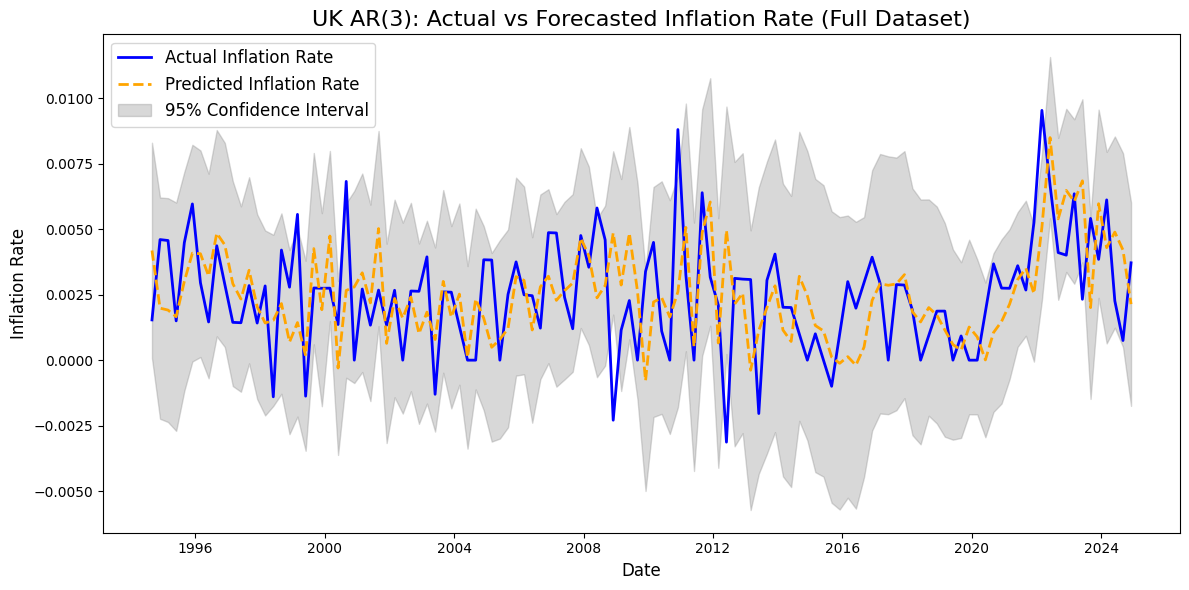

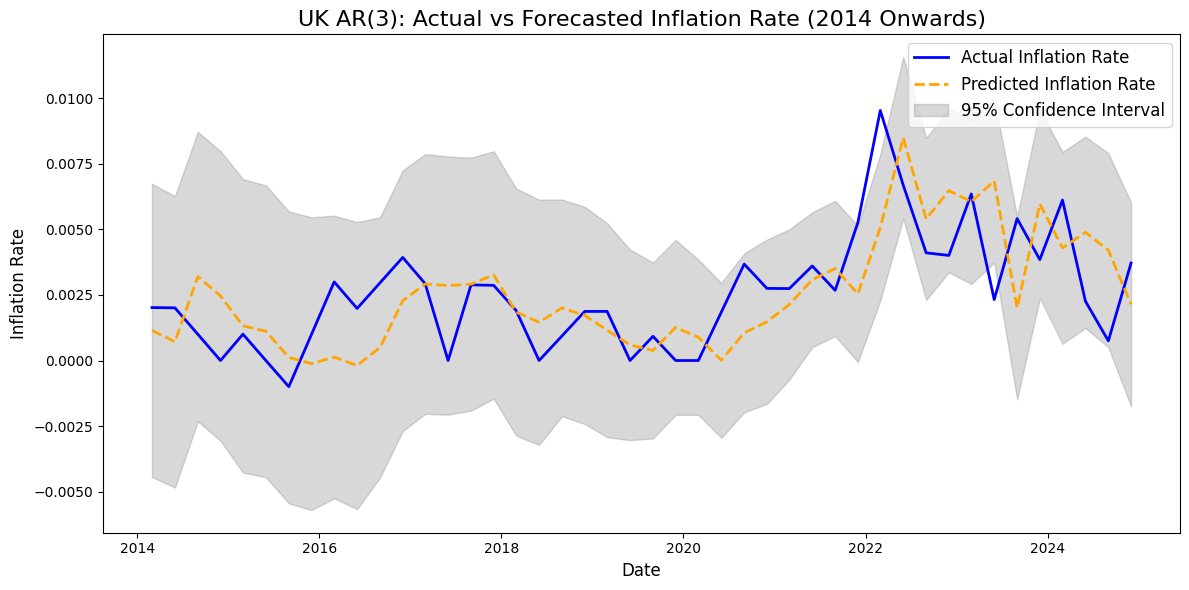

In [38]:
# Ensure the 'Date' column is in datetime format
uk_arp_forecast_results['Date'] = pd.to_datetime(uk_arp_forecast_results['Date'])

# Plot for the entire dataset
plt.figure(figsize=(12, 6))
plt.plot(uk_arp_forecast_results['Date'], uk_arp_forecast_results['Actual_infl_rate'], label='Actual Inflation Rate', color='blue', linewidth=2)
plt.plot(uk_arp_forecast_results['Date'], uk_arp_forecast_results['Forecast_infl_rate'], label='Predicted Inflation Rate', color='orange', linestyle='--', linewidth=2)

# Add 95% confidence intervals
plt.fill_between(uk_arp_forecast_results['Date'], 
                 uk_arp_forecast_results['Lower_95_FI'], 
                 uk_arp_forecast_results['Upper_95_FI'], 
                 color='gray', alpha=0.3, label='95% Confidence Interval')

# Add labels, title, and legend
plt.title(f'UK AR({uk_arp_lag}): Actual vs Forecasted Inflation Rate (Full Dataset)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Inflation Rate', fontsize=12)
plt.legend(fontsize=12)

# Format x-axis ticks to improve readability
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically determine tick frequency
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as years

# Adjust layout and show the plot
plt.tight_layout()
plt.show()





# Filter data from 2014 onwards
uk_arp_forecast_results_2014 = uk_arp_forecast_results[uk_arp_forecast_results['Date'] >= '2014-01-01']

# Plot for data from 2014 onwards
plt.figure(figsize=(12, 6))
plt.plot(uk_arp_forecast_results_2014['Date'], uk_arp_forecast_results_2014['Actual_infl_rate'], label='Actual Inflation Rate', color='blue', linewidth=2)
plt.plot(uk_arp_forecast_results_2014['Date'], uk_arp_forecast_results_2014['Forecast_infl_rate'], label='Predicted Inflation Rate', color='orange', linestyle='--', linewidth=2)

# Add 95% confidence intervals
plt.fill_between(uk_arp_forecast_results_2014['Date'], 
                 uk_arp_forecast_results_2014['Lower_95_FI'], 
                 uk_arp_forecast_results_2014['Upper_95_FI'], 
                 color='gray', alpha=0.3, label='95% Confidence Interval')

# Add labels, title, and legend
plt.title(f'UK AR({uk_arp_lag}): Actual vs Forecasted Inflation Rate (2014 Onwards)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Inflation Rate', fontsize=12)
plt.legend(fontsize=12)

# Format x-axis ticks to improve readability
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically determine tick frequency
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as years

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### ADL(`p`, `q`)

In [29]:
# Initialize a list to store results for all macroeconomic variables
all_results = []

# Loop through each macroeconomic variable in uk_adl_best_bic
for _, row in uk_adl_best_bic.iterrows():
    var = row['Variable']  # Macro variable name
    p = int(row['p'])      # Number of lags for infl_rate_diff
    q = int(row['q'])      # Number of lags for the macroeconomic variable

    # Create a copy of the dataset
    df_rolling = df_uk.copy()

    # Add lagged variables for infl_rate_diff up to p lags
    for lag in range(1, p + 1):
        df_rolling[f'infl_rate_diff_lag{lag}'] = df_rolling['infl_rate_diff'].shift(lag)

    # Add lagged variables for the macroeconomic variable up to q lags
    for lag in range(1, q + 1):
        df_rolling[f'{var}_lag{lag}'] = df_rolling[var].shift(lag)

    # Drop rows with NaN values due to lagging
    df_rolling = df_rolling.dropna()

    # Define dependent and independent variables
    y = df_rolling['infl_rate_diff']  # Dependent variable
    X = df_rolling[[f'infl_rate_diff_lag{lag}' for lag in range(1, p + 1)] +
                   [f'{var}_lag{lag}' for lag in range(1, q + 1)]]  # Independent variables
    X = sm.add_constant(X)  # Add a constant to the independent variables

    # Initialize variables for rolling window forecasting
    rolling_window_size = 30  # Set the rolling window size to 30
    forecasts_diff = []  # To store the forecasts for infl_rate_diff
    forecasts_infl_rate = []  # To store the forecasts for infl_rate
    forecast_intervals = []  # To store the forecast intervals for infl_rate
    actuals_infl_rate = df_rolling['infl_rate'].iloc[rolling_window_size:].tolist()  # Actual values for infl_rate

    # Ensure there are enough observations for the rolling window
    if len(df_rolling) < rolling_window_size:
        raise ValueError("Not enough data for the specified rolling window size.")

    # Start with the first rolling window
    for i in range(rolling_window_size, len(df_rolling)):
        # Define the rolling window
        X_rolling = X.iloc[i - rolling_window_size:i]  # Independent variables for the rolling window
        y_rolling = y.iloc[i - rolling_window_size:i]  # Dependent variable for the rolling window

        # Fit the model on the rolling window
        rolling_model = sm.OLS(y_rolling, X_rolling).fit()

        # Use the current observation for prediction
        current_row = X.iloc[i]
        forecast_diff = rolling_model.predict(current_row)  # Predict infl_rate_diff

        # Compute infl_rate_T = infl_rate_diff_T + infl_rate_T-1
        last_infl_rate = df_rolling.iloc[i - 1]['infl_rate']  # infl_rate at T-1
        forecast_infl_rate = forecast_diff.iloc[0] + last_infl_rate
        forecasts_infl_rate.append(forecast_infl_rate)  # Store the forecasted infl_rate

        # Calculate the standard error of the forecast
        se = np.sqrt(rolling_model.mse_resid)  # Standard error of residuals
        z = 1.96  # Critical value for 95% confidence interval
        lower_bound = forecast_infl_rate - z * se
        upper_bound = forecast_infl_rate + z * se
        forecast_intervals.append((lower_bound, upper_bound))  # Store the forecast interval

    # Calculate RMSE for infl_rate
    rmse_infl_rate = np.sqrt(mean_squared_error(actuals_infl_rate, forecasts_infl_rate))
    print(f"Result for {var}: ADL({p}, {q})")
    print(f"Root Mean Squared Error (RMSE) for infl_rate: {rmse_infl_rate:.4f}")

    # Store results for the current variable in a DataFrame
    results_df = pd.DataFrame({
        'Date': df_rolling['date'].iloc[rolling_window_size:].values,  # Extract the 'date' column
        'Macro_Variable': var,  # Add the macroeconomic variable name
        'Forecast_infl_rate': forecasts_infl_rate,
        'Actual_infl_rate': actuals_infl_rate,
        'Lower_95_CI': [interval[0] for interval in forecast_intervals],
        'Upper_95_CI': [interval[1] for interval in forecast_intervals]
    })

    # Append the results to the list
    all_results.append(results_df)

# Concatenate all results into a single DataFrame
uk_adl_forecast_results = pd.concat(all_results, ignore_index=True)

# Within 95% forecast interval
uk_adl_forecast_results['Within_95_CI'] = (uk_adl_forecast_results['Actual_infl_rate'] >= uk_adl_forecast_results['Lower_95_CI']) & (uk_adl_forecast_results['Actual_infl_rate'] <= uk_adl_forecast_results['Upper_95_CI'])

# Display the first few rows of the final results DataFrame
uk_adl_forecast_results

Result for cons_conf: ADL(3, 1)
Root Mean Squared Error (RMSE) for infl_rate: 0.0022
Result for gdp_pct_change: ADL(3, 3)
Root Mean Squared Error (RMSE) for infl_rate: 0.0027
Result for int_3m: ADL(3, 1)
Root Mean Squared Error (RMSE) for infl_rate: 0.0023
Result for ppi_diff: ADL(3, 4)
Root Mean Squared Error (RMSE) for infl_rate: 0.0025
Result for unm_rate: ADL(35, 20)
Root Mean Squared Error (RMSE) for infl_rate: 0.0058


Date Macro_Variable  Forecast_infl_rate  Actual_infl_rate  \
0   1994-09-01      cons_conf            0.004222          0.001536   
1   1994-12-01      cons_conf            0.002032          0.004601   
2   1995-03-01      cons_conf            0.001937          0.004566   
3   1995-06-01      cons_conf            0.001651          0.001499   
4   1995-09-01      cons_conf            0.002866          0.004484   
..         ...            ...                 ...               ...   
572 2023-12-01       unm_rate            0.001403          0.003846   
573 2024-03-01       unm_rate            0.010738          0.006116   
574 2024-06-01       unm_rate            0.008890          0.002261   
575 2024-09-01       unm_rate           -0.000600          0.000750   
576 2024-12-01       unm_rate            0.001029          0.003715   

     Lower_95_CI  Upper_95_CI  Within_95_CI  
0       0.000038     0.008406          True  
1      -0.002268     0.006331          True  
2      -0.002419     0.006292          True  
3      -0.002792     0.006094          True  
4      -0.001317     0.007050          True  
..           ...          ...           ...  
572          NaN          NaN         False  
573          NaN          NaN         False  
574          NaN          NaN         False  
575          NaN          NaN         False  
576          NaN          NaN         False  

[577 rows x 7 columns]

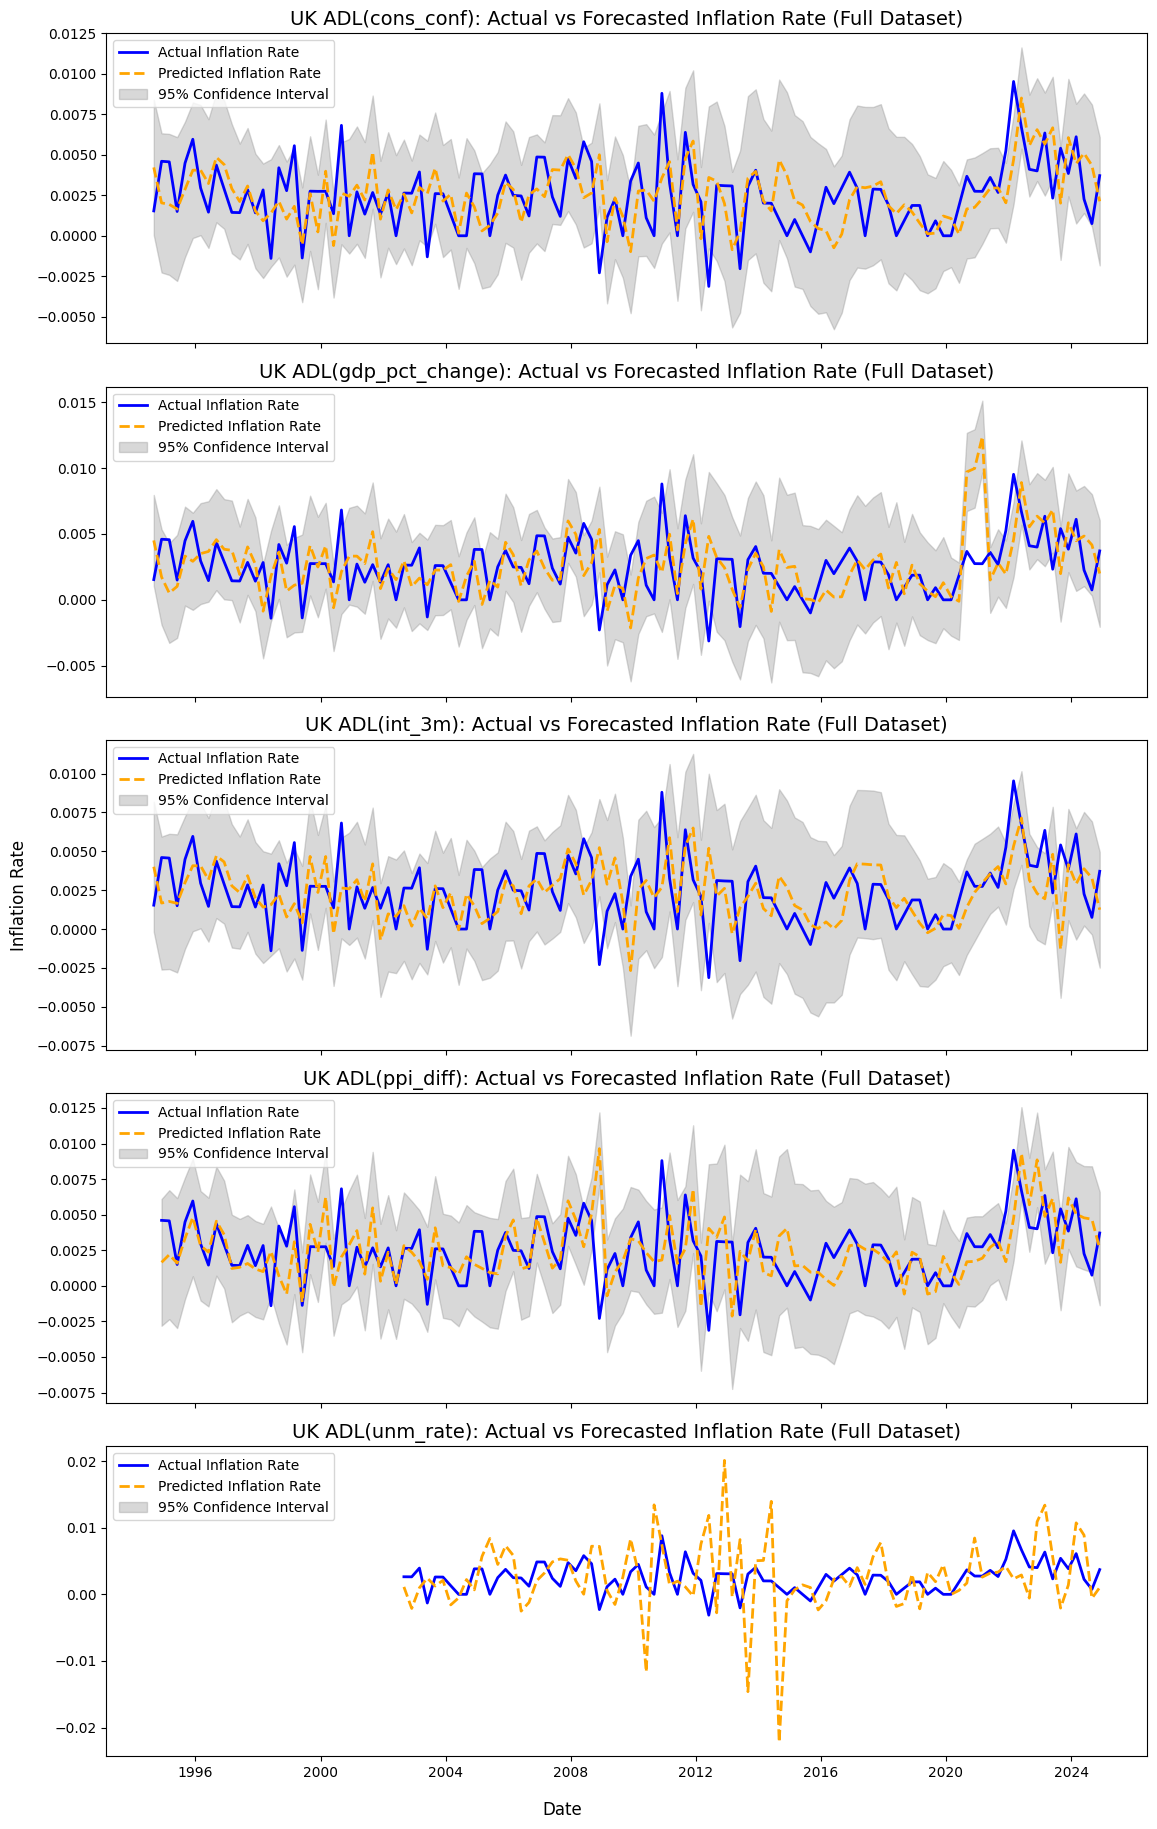

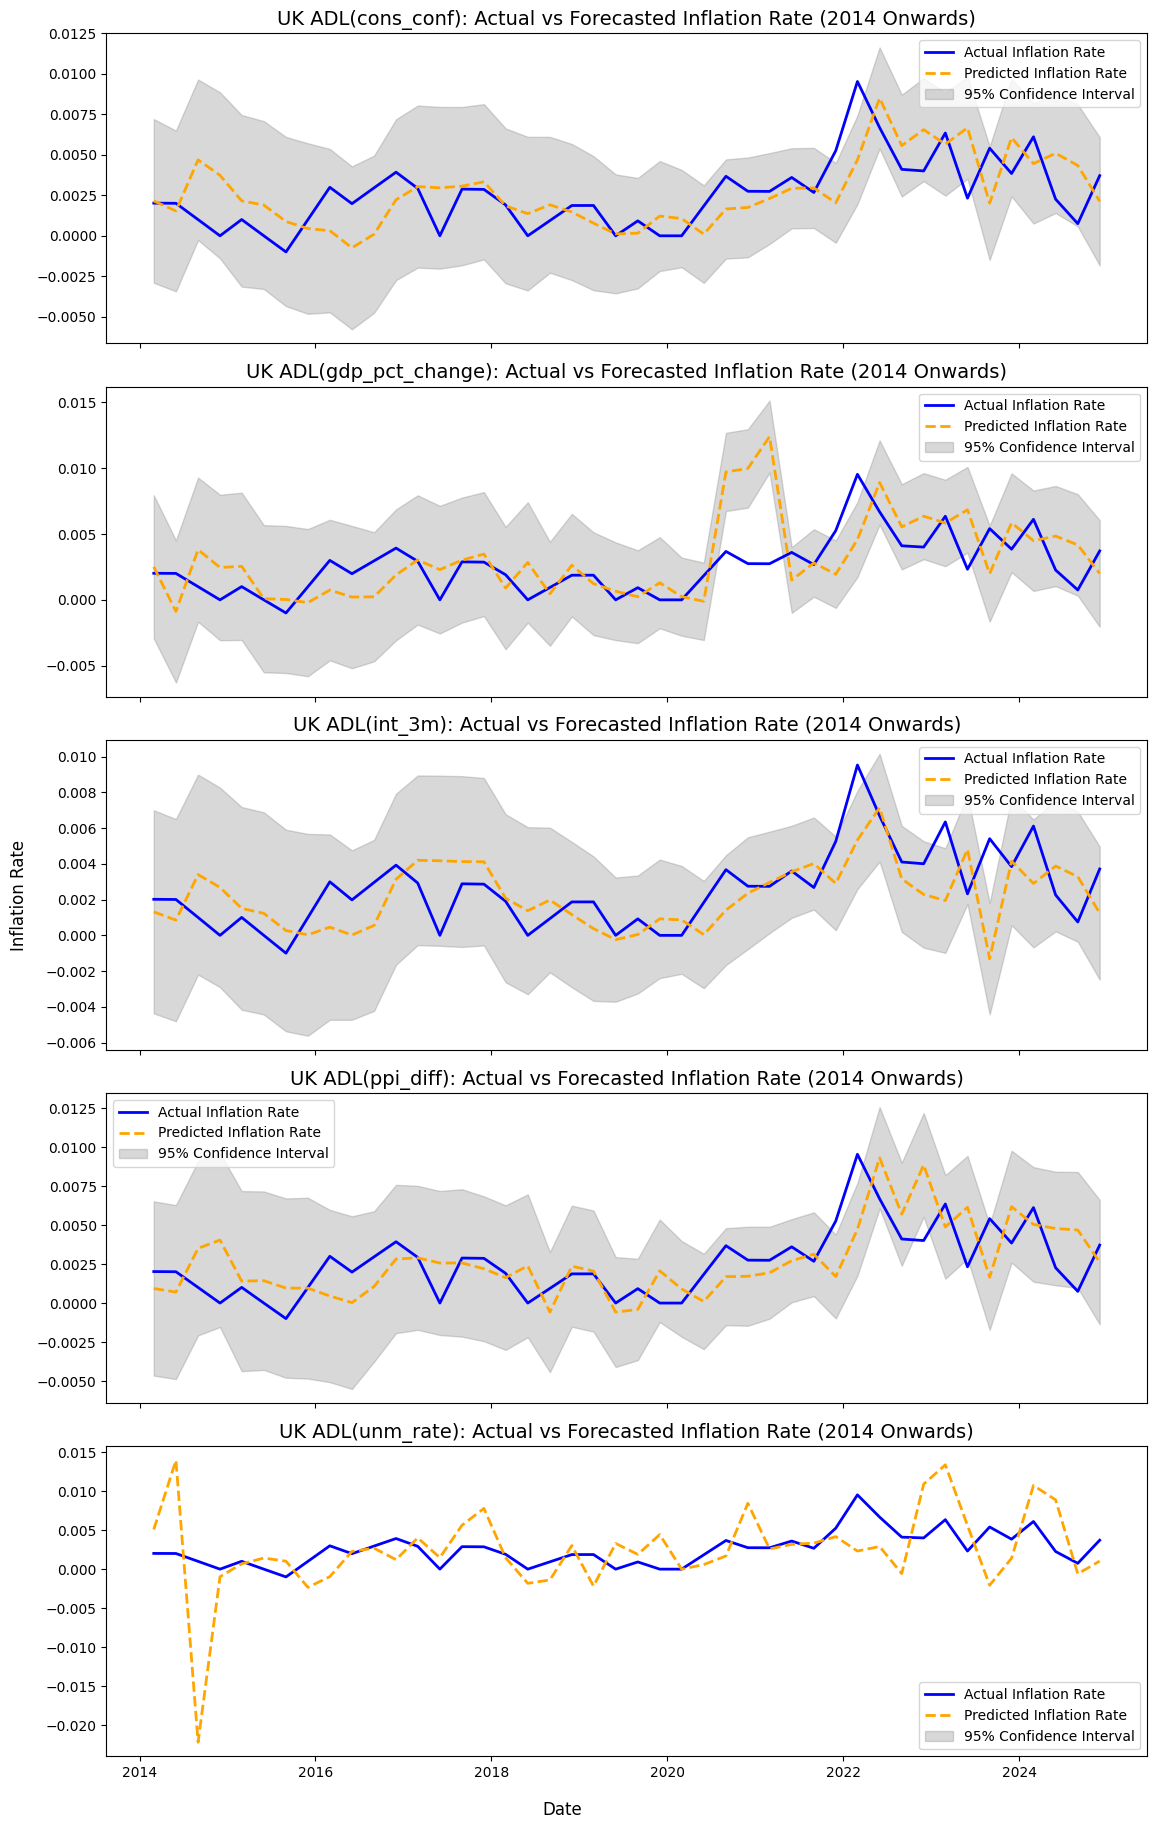

In [30]:
# Ensure the 'Date' column is in datetime format
uk_adl_forecast_results['Date'] = pd.to_datetime(uk_adl_forecast_results['Date'])

# Get the list of unique macroeconomic variables
macro_vars = uk_adl_forecast_results['Macro_Variable'].unique()

# Plot for the entire dataset
fig, axes = plt.subplots(len(macro_vars), 1, figsize=(12, 20), sharex=True)

for i, macro_var in enumerate(macro_vars):
    # Filter the results for the current macroeconomic variable
    macro_results = uk_adl_forecast_results[uk_adl_forecast_results['Macro_Variable'] == macro_var]
    
    # Plot actual vs. predicted inflation rate
    axes[i].plot(macro_results['Date'], macro_results['Actual_infl_rate'], label='Actual Inflation Rate', color='blue', linewidth=2)
    axes[i].plot(macro_results['Date'], macro_results['Forecast_infl_rate'], label='Predicted Inflation Rate', color='orange', linestyle='--', linewidth=2)
    
    # Add 95% confidence intervals
    axes[i].fill_between(macro_results['Date'], 
                         macro_results['Lower_95_CI'], 
                         macro_results['Upper_95_CI'], 
                         color='gray', alpha=0.3, label='95% Confidence Interval')
    
    # Add title for each subplot
    axes[i].set_title(f'UK ADL({macro_var}): Actual vs Forecasted Inflation Rate (Full Dataset)', fontsize=14)
    
    # Add legend to each subplot
    axes[i].legend(fontsize=10)
    
    # Format x-axis ticks to improve readability
    axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a common x-axis and y-axis label
fig.text(0.5, 0.04, 'Date', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Inflation Rate', va='center', rotation='vertical', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

# Show the plot for the entire dataset
plt.show()





# Filter data from 2014 onwards
uk_adl_forecast_results_2014 = uk_adl_forecast_results[uk_adl_forecast_results['Date'] >= '2014-01-01']

# Plot for data from 2014 onwards
fig, axes = plt.subplots(len(macro_vars), 1, figsize=(12, 20), sharex=True)

for i, macro_var in enumerate(macro_vars):
    # Filter the results for the current macroeconomic variable
    macro_results_2014 = uk_adl_forecast_results_2014[uk_adl_forecast_results_2014['Macro_Variable'] == macro_var]
    
    # Plot actual vs. predicted inflation rate
    axes[i].plot(macro_results_2014['Date'], macro_results_2014['Actual_infl_rate'], label='Actual Inflation Rate', color='blue', linewidth=2)
    axes[i].plot(macro_results_2014['Date'], macro_results_2014['Forecast_infl_rate'], label='Predicted Inflation Rate', color='orange', linestyle='--', linewidth=2)
    
    # Add 95% confidence intervals
    axes[i].fill_between(macro_results_2014['Date'], 
                         macro_results_2014['Lower_95_CI'], 
                         macro_results_2014['Upper_95_CI'], 
                         color='gray', alpha=0.3, label='95% Confidence Interval')
    
    # Add title for each subplot
    axes[i].set_title(f'UK ADL({macro_var}): Actual vs Forecasted Inflation Rate (2014 Onwards)', fontsize=14)
    
    # Add legend to each subplot
    axes[i].legend(fontsize=10)
    
    # Format x-axis ticks to improve readability
    axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a common x-axis and y-axis label
fig.text(0.5, 0.04, 'Date', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Inflation Rate', va='center', rotation='vertical', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

# Show the plot for 2014 onwards
plt.show()

## US

### AR(1)

In [31]:
# Create lagged variables for the regression
df_us_ar1_rolling = df_us.copy()
df_us_ar1_rolling['infl_rate_diff_lag1'] = df_us_ar1_rolling['infl_rate_diff'].shift(1)  # Lagged dependent variable

# Drop rows with NaN values due to lagging
df_us_ar1_rolling = df_us_ar1_rolling.dropna()

# Initialize variables for rolling window forecasting
results = []  # To store results as a list of dictionaries
rolling_window_size = 30  # Set the rolling window size to 30

# Ensure there are enough observations for the rolling window
if len(df_us_ar1_rolling) < rolling_window_size:
    raise ValueError("Not enough data for the specified rolling window size.")

# Start with the first rolling window
for i in range(rolling_window_size, len(df_us_ar1_rolling)):
    # Define the rolling window
    X_rolling = df_us_ar1_rolling.iloc[i - rolling_window_size:i][['infl_rate_diff_lag1']]  # Independent variables
    y_rolling = df_us_ar1_rolling.iloc[i - rolling_window_size:i]['infl_rate_diff']  # Dependent variable
    
    # Add a constant to the independent variables
    X_rolling = sm.add_constant(X_rolling)
    
    # Fit the model on the rolling window
    rolling_model = sm.OLS(y_rolling, X_rolling).fit()
    
    # Use the current observation for prediction
    current_row = df_us_ar1_rolling.iloc[i][['infl_rate_diff_lag1']]
    current_row = pd.DataFrame([current_row])  # Convert to DataFrame to match shape
    current_row = sm.add_constant(current_row, has_constant='add')  # Add a constant to match the model
    
    # Predict infl_rate_diff
    forecast_diff = rolling_model.predict(current_row)  # Predict infl_rate_diff
    
    # Compute infl_rate_T = infl_rate_diff_T + infl_rate_T-1
    last_infl_rate = df_us_ar1_rolling.iloc[i - 1]['infl_rate']  # infl_rate at T-1
    forecast_infl_rate = forecast_diff.iloc[0] + last_infl_rate
    
    # Calculate the standard error of the forecast
    se = np.sqrt(rolling_model.mse_resid)  # Standard error of residuals
    z = st.norm.ppf(0.975)  # Critical value for 95% confidence interval
    lower_bound = forecast_infl_rate - z * se
    upper_bound = forecast_infl_rate + z * se
    
    # Store the results in a dictionary
    results.append({
        'Date': df_us_ar1_rolling.iloc[i]['date'],
        'Forecast_infl_rate': forecast_infl_rate,
        'Actual_infl_rate': df_us_ar1_rolling.iloc[i]['infl_rate'],
        'Lower_95_CI': lower_bound,
        'Upper_95_CI': upper_bound
    })

# Convert results to a pandas DataFrame
us_ar1_forecast_results = pd.DataFrame(results)

# Calculate RMSE for infl_rate
rmse_infl_rate = np.sqrt(mean_squared_error(us_ar1_forecast_results['Actual_infl_rate'], us_ar1_forecast_results['Forecast_infl_rate']))
print(f"Root Mean Squared Error (RMSE) for infl_rate: {rmse_infl_rate:.4f}")

# Within 95% forecast interval
us_ar1_forecast_results['Within_95_CI'] = (us_ar1_forecast_results['Actual_infl_rate'] >= us_ar1_forecast_results['Lower_95_CI']) & (us_ar1_forecast_results['Actual_infl_rate'] <= us_ar1_forecast_results['Upper_95_CI'])

# Display us_ar1_forecast_results
us_ar1_forecast_results

Root Mean Squared Error (RMSE) for infl_rate: 0.0033


Date  Forecast_infl_rate  Actual_infl_rate  Lower_95_CI  Upper_95_CI  \
0  2011-06-01            0.004837          0.000000    -0.005986     0.015660   
1  2011-09-01            0.001920          0.002172    -0.009045     0.012885   
2  2011-12-01            0.001301          0.000238    -0.009661     0.012263   
3  2012-03-01            0.000870          0.002093    -0.010086     0.011826   
4  2012-06-01            0.001290         -0.000826    -0.009675     0.012255   
5  2012-09-01            0.000285          0.004771    -0.010639     0.011208   
6  2012-12-01            0.002559         -0.000121    -0.008453     0.013571   
7  2013-03-01            0.001871         -0.002812    -0.009167     0.012909   
8  2013-06-01           -0.002425          0.002380    -0.012594     0.007744   
9  2013-09-01            0.001137          0.000377    -0.008556     0.010829   
10 2013-12-01            0.000894          0.002644    -0.008778     0.010565   
11 2014-03-01            0.002018          0.002042    -0.007661     0.011697   
12 2014-06-01            0.002434          0.001321    -0.006866     0.011734   
13 2014-09-01            0.001347          0.000072    -0.007389     0.010083   
14 2014-12-01            0.000123         -0.003085    -0.008599     0.008845   
15 2015-03-01           -0.002684          0.002694    -0.011428     0.006060   
16 2015-06-01            0.001362          0.002768    -0.007581     0.010306   
17 2015-09-01            0.002739         -0.002248    -0.006212     0.011690   
18 2015-12-01           -0.001448         -0.001076    -0.010578     0.007683   
19 2016-03-01           -0.001749          0.003135    -0.010466     0.006968   
20 2016-06-01            0.002745          0.002776    -0.005582     0.011073   
21 2016-09-01            0.003270          0.002623    -0.003963     0.010503   
22 2016-12-01            0.002847          0.002525    -0.004177     0.009870   
23 2017-03-01            0.002419         -0.000467    -0.003197     0.008035   
24 2017-06-01            0.000335          0.000652    -0.005281     0.005951   
25 2017-09-01            0.000178          0.005106    -0.005278     0.005635   
26 2017-12-01            0.003569          0.002107    -0.002165     0.009303   
27 2018-03-01            0.003471          0.000192    -0.002275     0.009216   
28 2018-06-01            0.000875          0.000901    -0.004954     0.006703   
29 2018-09-01            0.000504          0.002062    -0.005201     0.006208   
30 2018-12-01            0.001448          0.000685    -0.004226     0.007122   
31 2019-03-01            0.001200          0.003782    -0.004216     0.006616   
32 2019-06-01            0.002616         -0.000325    -0.002881     0.008113   
33 2019-09-01            0.001412          0.001539    -0.004173     0.006996   
34 2019-12-01            0.000736          0.002912    -0.004835     0.006307   
35 2020-03-01            0.002498         -0.004528    -0.003066     0.008062   
36 2020-06-01           -0.002037          0.004847    -0.007913     0.003840   
37 2020-09-01            0.000284          0.002626    -0.005975     0.006543   
38 2020-12-01            0.004001          0.004346    -0.002008     0.010011   
39 2021-03-01            0.003684          0.004834    -0.002172     0.009539   
40 2021-06-01            0.004783          0.008592    -0.001087     0.010653   
41 2021-09-01            0.007127          0.004363     0.001109     0.013146   
42 2021-12-01            0.006615          0.007108     0.000517     0.012713   
43 2022-03-01            0.005968          0.010340    -0.000115     0.012052   
44 2022-06-01            0.009245          0.012952     0.003003     0.015486   
45 2022-09-01            0.012438          0.004265     0.006262     0.018615   
46 2022-12-01            0.008670          0.000335     0.001972     0.015369   
47 2023-03-01            0.001560          0.000554    -0.005641     0.008760   
48 2023-06-01            0.000552       

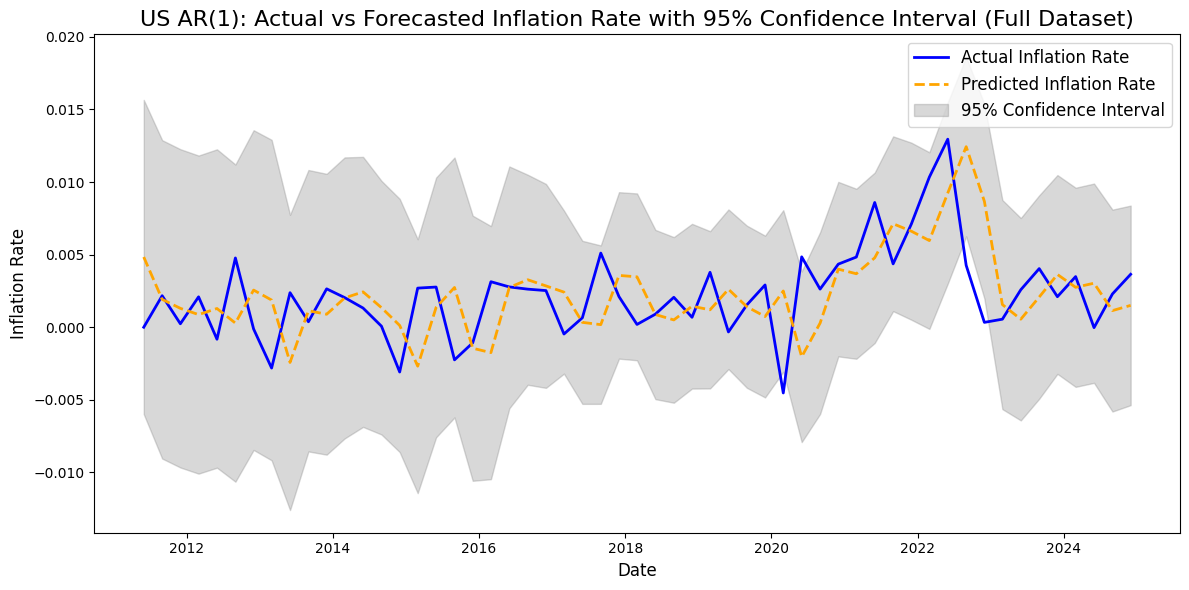

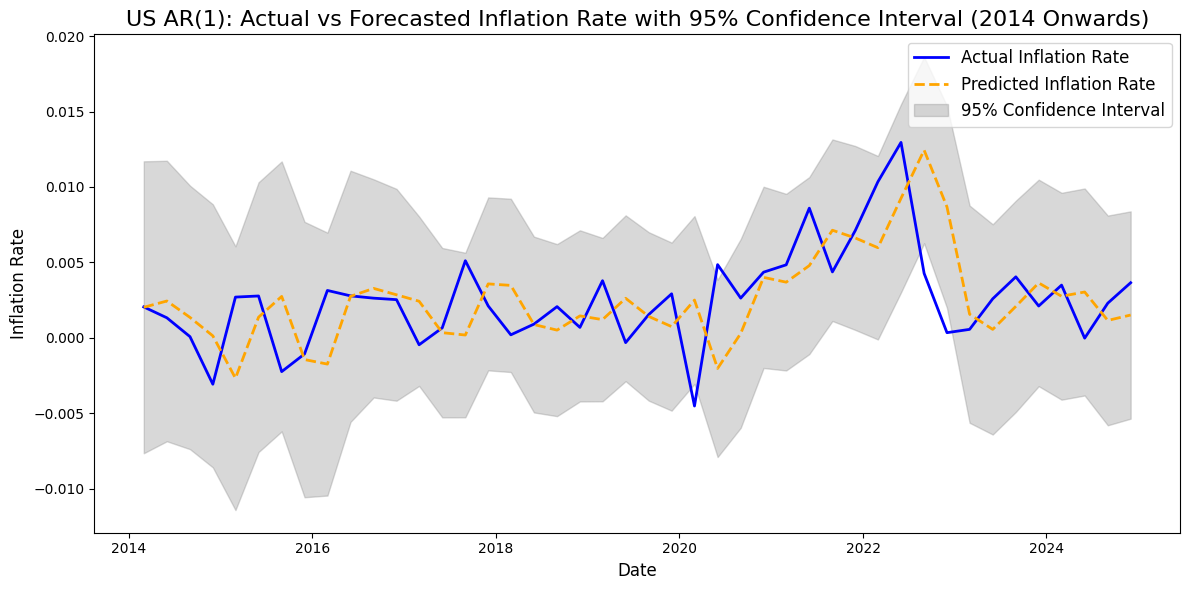

In [32]:
# Ensure the 'Date' column is in datetime format
us_ar1_forecast_results['Date'] = pd.to_datetime(us_ar1_forecast_results['Date'])

# Plot actual vs. predicted inflation rate
plt.figure(figsize=(12, 6))
plt.plot(us_ar1_forecast_results['Date'], us_ar1_forecast_results['Actual_infl_rate'], label='Actual Inflation Rate', color='blue', linewidth=2)
plt.plot(us_ar1_forecast_results['Date'], us_ar1_forecast_results['Forecast_infl_rate'], label='Predicted Inflation Rate', color='orange', linestyle='--', linewidth=2)

# Add 95% confidence intervals
plt.fill_between(us_ar1_forecast_results['Date'], 
                 us_ar1_forecast_results['Lower_95_CI'], 
                 us_ar1_forecast_results['Upper_95_CI'], 
                 color='gray', alpha=0.3, label='95% Confidence Interval')

# Add labels, title, and legend
plt.title('US AR(1): Actual vs Forecasted Inflation Rate with 95% Confidence Interval (Full Dataset)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Inflation Rate', fontsize=12)
plt.legend(fontsize=12)

# Format x-axis ticks to improve readability
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically determine tick frequency
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as years

# Adjust layout and show the plot
plt.tight_layout()
plt.show()





# Filter data from 2014 onwards
us_ar1_forecast_results_2014 = us_ar1_forecast_results[us_ar1_forecast_results['Date'] >= '2014-01-01']

# Plot actual vs. predicted inflation rate
plt.figure(figsize=(12, 6))
plt.plot(us_ar1_forecast_results_2014['Date'], us_ar1_forecast_results_2014['Actual_infl_rate'], label='Actual Inflation Rate', color='blue', linewidth=2)
plt.plot(us_ar1_forecast_results_2014['Date'], us_ar1_forecast_results_2014['Forecast_infl_rate'], label='Predicted Inflation Rate', color='orange', linestyle='--', linewidth=2)

# Add 95% confidence intervals
plt.fill_between(us_ar1_forecast_results_2014['Date'], 
                 us_ar1_forecast_results_2014['Lower_95_CI'], 
                 us_ar1_forecast_results_2014['Upper_95_CI'], 
                 color='gray', alpha=0.3, label='95% Confidence Interval')

# Add labels, title, and legend
plt.title('US AR(1): Actual vs Forecasted Inflation Rate with 95% Confidence Interval (2014 Onwards)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Inflation Rate', fontsize=12)
plt.legend(fontsize=12)

# Format x-axis ticks to improve readability
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically determine tick frequency
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as years

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### AR(`p`)

In [33]:
# Create lagged variables for AR(p) model
df_us_arp_rolling = df_us.copy()

# Add lagged variables for infl_rate_diff up to the pth lag
for lag in range(1, us_arp_lag+1):  # Create lags from 1 to p
    df_us_arp_rolling[f'infl_rate_diff_lag{lag}'] = df_us_arp_rolling['infl_rate_diff'].shift(lag)

# Drop rows with NaN values due to lagging
df_us_arp_rolling = df_us_arp_rolling.dropna()

# Define dependent and independent variables
y = df_us_arp_rolling['infl_rate_diff']  # Dependent variable
X = df_us_arp_rolling[[f'infl_rate_diff_lag{lag}' for lag in range(1, us_arp_lag+1)]]  # Include all lagged variables
X = sm.add_constant(X)  # Add a constant to the independent variables

# Initialize variables for rolling window forecasting
rolling_window_size = 30  # Set the rolling window size to 30
forecasts_diff = []  # To store the forecasts for infl_rate_diff
forecasts_infl_rate = []  # To store the forecasts for infl_rate
forecast_intervals = []  # To store the forecast intervals for infl_rate
actuals_infl_rate = df_us_arp_rolling['infl_rate'].iloc[rolling_window_size:].tolist()  # Actual values for infl_rate

# Ensure there are enough observations for the rolling window
if len(df_us_arp_rolling) < rolling_window_size:
    raise ValueError("Not enough data for the specified rolling window size.")

# Start with the first rolling window
for i in range(rolling_window_size, len(df_us_arp_rolling)):
    # Define the rolling window
    X_rolling = X.iloc[i - rolling_window_size:i]  # Independent variables for the rolling window
    y_rolling = y.iloc[i - rolling_window_size:i]  # Dependent variable for the rolling window
    
    # Fit the AR(p) model on the rolling window
    rolling_model = sm.OLS(y_rolling, X_rolling).fit()
    
    # Use the current observation for prediction
    current_row = X.iloc[i]
    forecast_diff = rolling_model.predict(current_row)  # Predict infl_rate_diff
    
    # Compute infl_rate_T = infl_rate_diff_T + infl_rate_T-1
    last_infl_rate = df_us_arp_rolling.iloc[i - 1]['infl_rate']  # infl_rate at T-1
    forecast_infl_rate = forecast_diff.iloc[0] + last_infl_rate
    forecasts_infl_rate.append(forecast_infl_rate)  # Store the forecasted infl_rate
    
    # Calculate the standard error of the forecast
    se = np.sqrt(rolling_model.mse_resid)  # Standard error of residuals
    z = 1.96  # Critical value for 95% confidence interval
    lower_bound = forecast_infl_rate - z * se
    upper_bound = forecast_infl_rate + z * se
    forecast_intervals.append((lower_bound, upper_bound))  # Store the forecast interval

# Calculate RMSE for infl_rate
rmse_infl_rate = np.sqrt(mean_squared_error(actuals_infl_rate, forecasts_infl_rate))
print(f"Root Mean Squared Error (RMSE) for infl_rate: {rmse_infl_rate:.4f}")

# Store results in a pandas DataFrame
us_arp_forecast_results = pd.DataFrame({
    'Date': df_us_arp_rolling['date'].iloc[rolling_window_size:].values,  # Extract the 'date' column starting from the rolling window size
    'Forecast_infl_rate': forecasts_infl_rate,
    'Actual_infl_rate': actuals_infl_rate,
    'Lower_95_CI': [interval[0] for interval in forecast_intervals],
    'Upper_95_CI': [interval[1] for interval in forecast_intervals]
})

# Within 95% forecast interval
us_arp_forecast_results['Within_95_CI'] = (us_arp_forecast_results['Actual_infl_rate'] >= us_arp_forecast_results['Lower_95_CI']) & (us_arp_forecast_results['Actual_infl_rate'] <= us_arp_forecast_results['Upper_95_CI'])

# Display the first few rows of the results DataFrame
us_arp_forecast_results

Root Mean Squared Error (RMSE) for infl_rate: 0.0032


Date  Forecast_infl_rate  Actual_infl_rate  Lower_95_CI  Upper_95_CI  \
0  2011-09-01            0.002323          0.002172    -0.007761     0.012406   
1  2011-12-01            0.003210          0.000238    -0.006874     0.013293   
2  2012-03-01            0.000233          0.002093    -0.009900     0.010365   
3  2012-06-01            0.001778         -0.000826    -0.008377     0.011934   
4  2012-09-01           -0.000064          0.004771    -0.010214     0.010087   
5  2012-12-01            0.002824         -0.000121    -0.007465     0.013113   
6  2013-03-01            0.000385         -0.002812    -0.009925     0.010695   
7  2013-06-01            0.000283          0.002380    -0.008767     0.009333   
8  2013-09-01            0.001244          0.000377    -0.007262     0.009749   
9  2013-12-01           -0.001492          0.002644    -0.009968     0.006984   
10 2014-03-01            0.002788          0.002042    -0.005617     0.011193   
11 2014-06-01            0.001353          0.001321    -0.006711     0.009416   
12 2014-09-01            0.001780          0.000072    -0.005680     0.009241   
13 2014-12-01            0.000706         -0.003085    -0.006778     0.008190   
14 2015-03-01           -0.001776          0.002694    -0.009328     0.005777   
15 2015-06-01            0.002357          0.002768    -0.005362     0.010076   
16 2015-09-01           -0.000575         -0.002248    -0.008252     0.007102   
17 2015-12-01           -0.000946         -0.001076    -0.008624     0.006732   
18 2016-03-01            0.000917          0.003135    -0.006334     0.008168   
19 2016-06-01            0.001415          0.002776    -0.005372     0.008202   
20 2016-09-01            0.001152          0.002623    -0.004888     0.007191   
21 2016-12-01            0.003137          0.002525    -0.002920     0.009195   
22 2017-03-01            0.002605         -0.000467    -0.002545     0.007755   
23 2017-06-01            0.000902          0.000652    -0.004368     0.006172   
24 2017-09-01            0.000902          0.005106    -0.004341     0.006144   
25 2017-12-01            0.002264          0.002107    -0.003041     0.007568   
26 2018-03-01            0.001967          0.000192    -0.003302     0.007236   
27 2018-06-01            0.002733          0.000901    -0.002547     0.008012   
28 2018-09-01            0.001266          0.002062    -0.003915     0.006446   
29 2018-12-01            0.000830          0.000685    -0.004177     0.005836   
30 2019-03-01            0.000860          0.003782    -0.003997     0.005717   
31 2019-06-01            0.002603         -0.000325    -0.002371     0.007577   
32 2019-09-01            0.000681          0.001539    -0.004277     0.005640   
33 2019-12-01            0.002464          0.002912    -0.002462     0.007389   
34 2020-03-01            0.001198         -0.004528    -0.003612     0.006009   
35 2020-06-01           -0.001068          0.004847    -0.005961     0.003825   
36 2020-09-01            0.003017          0.002626    -0.002171     0.008205   
37 2020-12-01           -0.001192          0.004346    -0.006269     0.003884   
38 2021-03-01            0.004365          0.004834    -0.001003     0.009733   
39 2021-06-01            0.004038          0.008592    -0.001333     0.009409   
40 2021-09-01            0.006186          0.004363     0.000653     0.011719   
41 2021-12-01            0.005879          0.007108     0.000308     0.011451   
42 2022-03-01            0.007380          0.010340     0.001794     0.012966   
43 2022-06-01            0.007217          0.012952     0.001610     0.012824   
44 2022-09-01            0.010652          0.004265     0.004994     0.016310   
45 2022-12-01            0.009707          0.000335     0.003661     0.015753   
46 2023-03-01            0.006309          0.000554    -0.000473     0.013091   
47 2023-06-01            0.001477          0.002581    -0.005411     0.008366   
48 2023-09-01            0.001839       

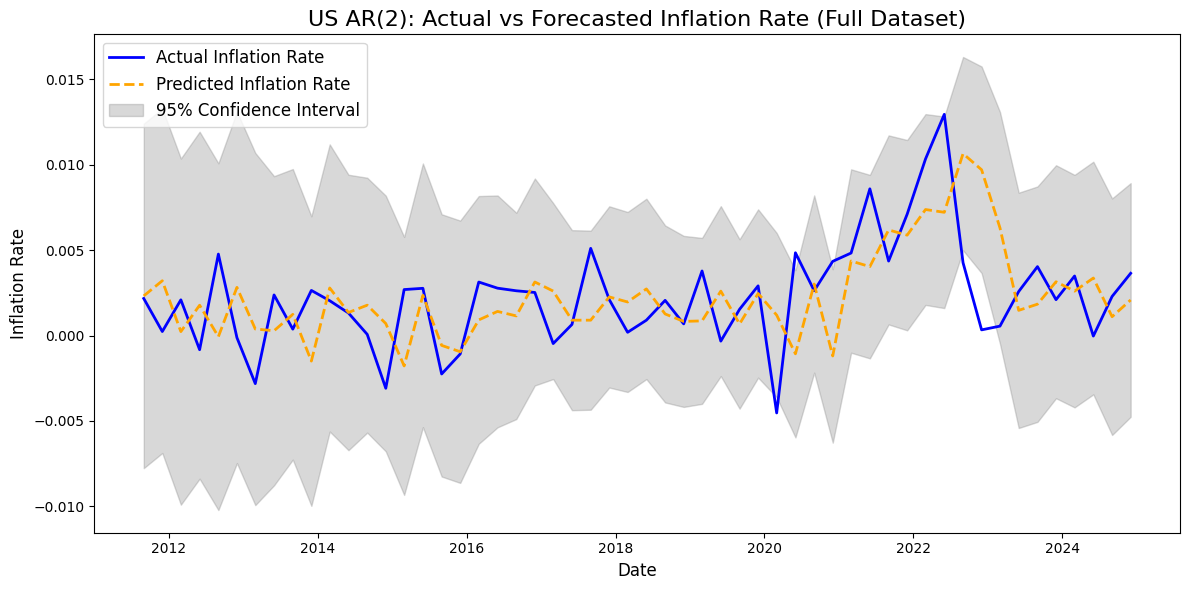

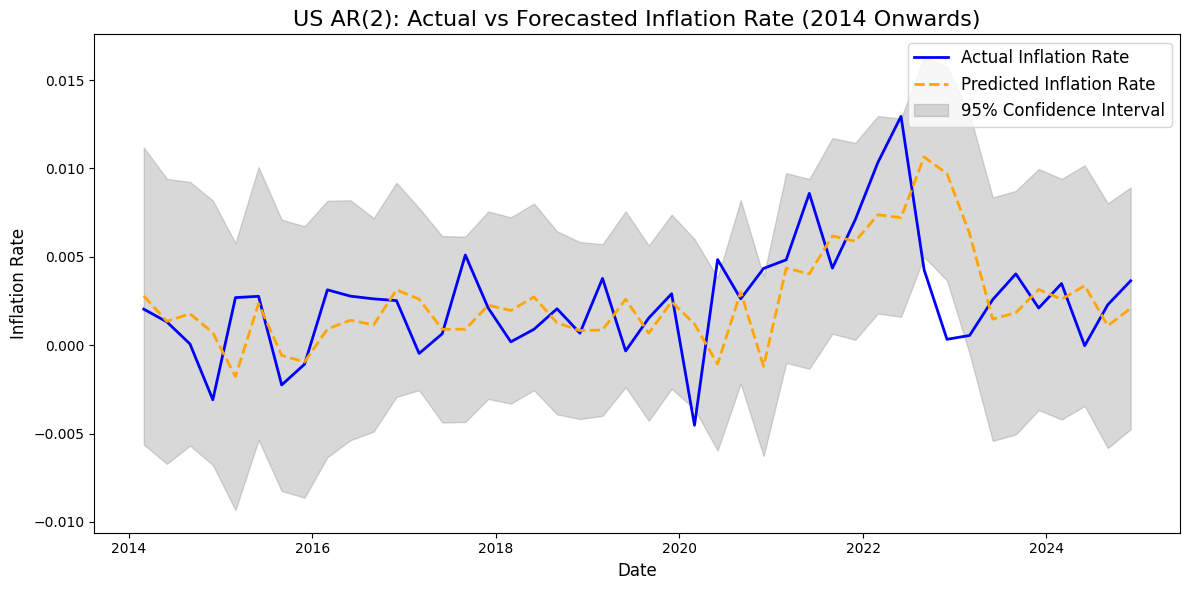

In [39]:
# Ensure the 'Date' column is in datetime format
us_arp_forecast_results['Date'] = pd.to_datetime(us_arp_forecast_results['Date'])

# Plot for the entire dataset
plt.figure(figsize=(12, 6))
plt.plot(us_arp_forecast_results['Date'], us_arp_forecast_results['Actual_infl_rate'], label='Actual Inflation Rate', color='blue', linewidth=2)
plt.plot(us_arp_forecast_results['Date'], us_arp_forecast_results['Forecast_infl_rate'], label='Predicted Inflation Rate', color='orange', linestyle='--', linewidth=2)

# Add 95% confidence intervals
plt.fill_between(us_arp_forecast_results['Date'], 
                 us_arp_forecast_results['Lower_95_CI'], 
                 us_arp_forecast_results['Upper_95_CI'], 
                 color='gray', alpha=0.3, label='95% Confidence Interval')

# Add labels, title, and legend
plt.title(f'US AR({us_arp_lag}): Actual vs Forecasted Inflation Rate (Full Dataset)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Inflation Rate', fontsize=12)
plt.legend(fontsize=12)

# Format x-axis ticks to improve readability
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically determine tick frequency
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as years

# Adjust layout and show the plot
plt.tight_layout()
plt.show()





# Filter data from 2014 onwards
us_arp_forecast_results_2014 = us_arp_forecast_results[us_arp_forecast_results['Date'] >= '2014-01-01']

# Plot for the entire dataset
plt.figure(figsize=(12, 6))
plt.plot(us_arp_forecast_results_2014['Date'], us_arp_forecast_results_2014['Actual_infl_rate'], label='Actual Inflation Rate', color='blue', linewidth=2)
plt.plot(us_arp_forecast_results_2014['Date'], us_arp_forecast_results_2014['Forecast_infl_rate'], label='Predicted Inflation Rate', color='orange', linestyle='--', linewidth=2)

# Add 95% confidence intervals
plt.fill_between(us_arp_forecast_results_2014['Date'], 
                 us_arp_forecast_results_2014['Lower_95_CI'], 
                 us_arp_forecast_results_2014['Upper_95_CI'], 
                 color='gray', alpha=0.3, label='95% Confidence Interval')

# Add labels, title, and legend
plt.title(f'US AR({us_arp_lag}): Actual vs Forecasted Inflation Rate (2014 Onwards)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Inflation Rate', fontsize=12)
plt.legend(fontsize=12)

# Format x-axis ticks to improve readability
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically determine tick frequency
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as years

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### ADL(`p`, `q`)

In [35]:
# Initialize a list to store results for all macroeconomic variables
all_results = []

# Loop through each macroeconomic variable in us_adl_best_bic
for _, row in us_adl_best_bic.iterrows():
    var = row['Variable']  # Macro variable name
    p = int(row['p'])      # Number of lags for infl_rate_diff
    q = int(row['q'])      # Number of lags for the macroeconomic variable

    # Create a copy of the dataset
    df_rolling = df_us.copy()

    # Add lagged variables for infl_rate_diff up to p lags
    for lag in range(1, p + 1):
        df_rolling[f'infl_rate_diff_lag{lag}'] = df_rolling['infl_rate_diff'].shift(lag)

    # Add lagged variables for the macroeconomic variable up to q lags
    for lag in range(1, q + 1):
        df_rolling[f'{var}_lag{lag}'] = df_rolling[var].shift(lag)

    # Drop rows with NaN values due to lagging
    df_rolling = df_rolling.dropna()

    # Define dependent and independent variables
    y = df_rolling['infl_rate_diff']  # Dependent variable
    X = df_rolling[[f'infl_rate_diff_lag{lag}' for lag in range(1, p + 1)] +
                   [f'{var}_lag{lag}' for lag in range(1, q + 1)]]  # Independent variables
    X = sm.add_constant(X)  # Add a constant to the independent variables

    # Initialize variables for rolling window forecasting
    rolling_window_size = 30  # Set the rolling window size to 30
    forecasts_diff = []  # To store the forecasts for infl_rate_diff
    forecasts_infl_rate = []  # To store the forecasts for infl_rate
    forecast_intervals = []  # To store the forecast intervals for infl_rate
    actuals_infl_rate = df_rolling['infl_rate'].iloc[rolling_window_size:].tolist()  # Actual values for infl_rate

    # Ensure there are enough observations for the rolling window
    if len(df_rolling) < rolling_window_size:
        raise ValueError("Not enough data for the specified rolling window size.")

    # Start with the first rolling window
    for i in range(rolling_window_size, len(df_rolling)):
        # Define the rolling window
        X_rolling = X.iloc[i - rolling_window_size:i]  # Independent variables for the rolling window
        y_rolling = y.iloc[i - rolling_window_size:i]  # Dependent variable for the rolling window

        # Fit the model on the rolling window
        rolling_model = sm.OLS(y_rolling, X_rolling).fit()

        # Use the current observation for prediction
        current_row = X.iloc[i]
        forecast_diff = rolling_model.predict(current_row)  # Predict infl_rate_diff

        # Compute infl_rate_T = infl_rate_diff_T + infl_rate_T-1
        last_infl_rate = df_rolling.iloc[i - 1]['infl_rate']  # infl_rate at T-1
        forecast_infl_rate = forecast_diff.iloc[0] + last_infl_rate
        forecasts_infl_rate.append(forecast_infl_rate)  # Store the forecasted infl_rate

        # Calculate the standard error of the forecast
        se = np.sqrt(rolling_model.mse_resid)  # Standard error of residuals
        z = 1.96  # Critical value for 95% confidence interval
        lower_bound = forecast_infl_rate - z * se
        upper_bound = forecast_infl_rate + z * se
        forecast_intervals.append((lower_bound, upper_bound))  # Store the forecast interval

    # Calculate RMSE for infl_rate
    rmse_infl_rate = np.sqrt(mean_squared_error(actuals_infl_rate, forecasts_infl_rate))
    print(f"Result for {var}: ADL({p}, {q})")
    print(f"Root Mean Squared Error (RMSE) for infl_rate: {rmse_infl_rate:.4f}")

    # Store results for the current variable in a DataFrame
    results_df = pd.DataFrame({
        'Date': df_rolling['date'].iloc[rolling_window_size:].values,  # Extract the 'date' column
        'Macro_Variable': var,  # Add the macroeconomic variable name
        'Forecast_infl_rate': forecasts_infl_rate,
        'Actual_infl_rate': actuals_infl_rate,
        'Lower_95_CI': [interval[0] for interval in forecast_intervals],
        'Upper_95_CI': [interval[1] for interval in forecast_intervals]
    })

    # Append the results to the list
    all_results.append(results_df)

# Concatenate all results into a single DataFrame
us_adl_forecast_results = pd.concat(all_results, ignore_index=True)

# Within 95% forecast interval
us_adl_forecast_results['Within_95_CI'] = (us_adl_forecast_results['Actual_infl_rate'] >= us_adl_forecast_results['Lower_95_CI']) & (us_adl_forecast_results['Actual_infl_rate'] <= us_adl_forecast_results['Upper_95_CI'])

# Display the first few rows of the final results DataFrame
us_adl_forecast_results

Result for cons_conf: ADL(2, 2)
Root Mean Squared Error (RMSE) for infl_rate: 0.0035
Result for gdp_pct_change: ADL(2, 2)
Root Mean Squared Error (RMSE) for infl_rate: 0.0046
Result for int_3m: ADL(14, 13)
Root Mean Squared Error (RMSE) for infl_rate: 0.0165
Result for ppi_diff: ADL(2, 3)
Root Mean Squared Error (RMSE) for infl_rate: 0.0038
Result for unm_rate: ADL(2, 1)
Root Mean Squared Error (RMSE) for infl_rate: 0.0032


Date Macro_Variable  Forecast_infl_rate  Actual_infl_rate  \
0   2011-09-01      cons_conf            0.001121          0.002172   
1   2011-12-01      cons_conf            0.000621          0.000238   
2   2012-03-01      cons_conf            0.002434          0.002093   
3   2012-06-01      cons_conf            0.003774         -0.000826   
4   2012-09-01      cons_conf           -0.000559          0.004771   
..         ...            ...                 ...               ...   
252 2023-12-01       unm_rate            0.002686          0.002103   
253 2024-03-01       unm_rate            0.002400          0.003488   
254 2024-06-01       unm_rate            0.003012         -0.000029   
255 2024-09-01       unm_rate            0.001192          0.002292   
256 2024-12-01       unm_rate            0.001747          0.003647   

     Lower_95_CI  Upper_95_CI  Within_95_CI  
0      -0.009046     0.011288          True  
1      -0.009522     0.010765          True  
2      -0.007711     0.012579          True  
3      -0.006368     0.013916          True  
4      -0.010740     0.009623          True  
..           ...          ...           ...  
252    -0.004154     0.009525          True  
253    -0.004412     0.009211          True  
254    -0.003809     0.009834          True  
255    -0.005722     0.008105          True  
256    -0.005070     0.008564          True  

[257 rows x 7 columns]

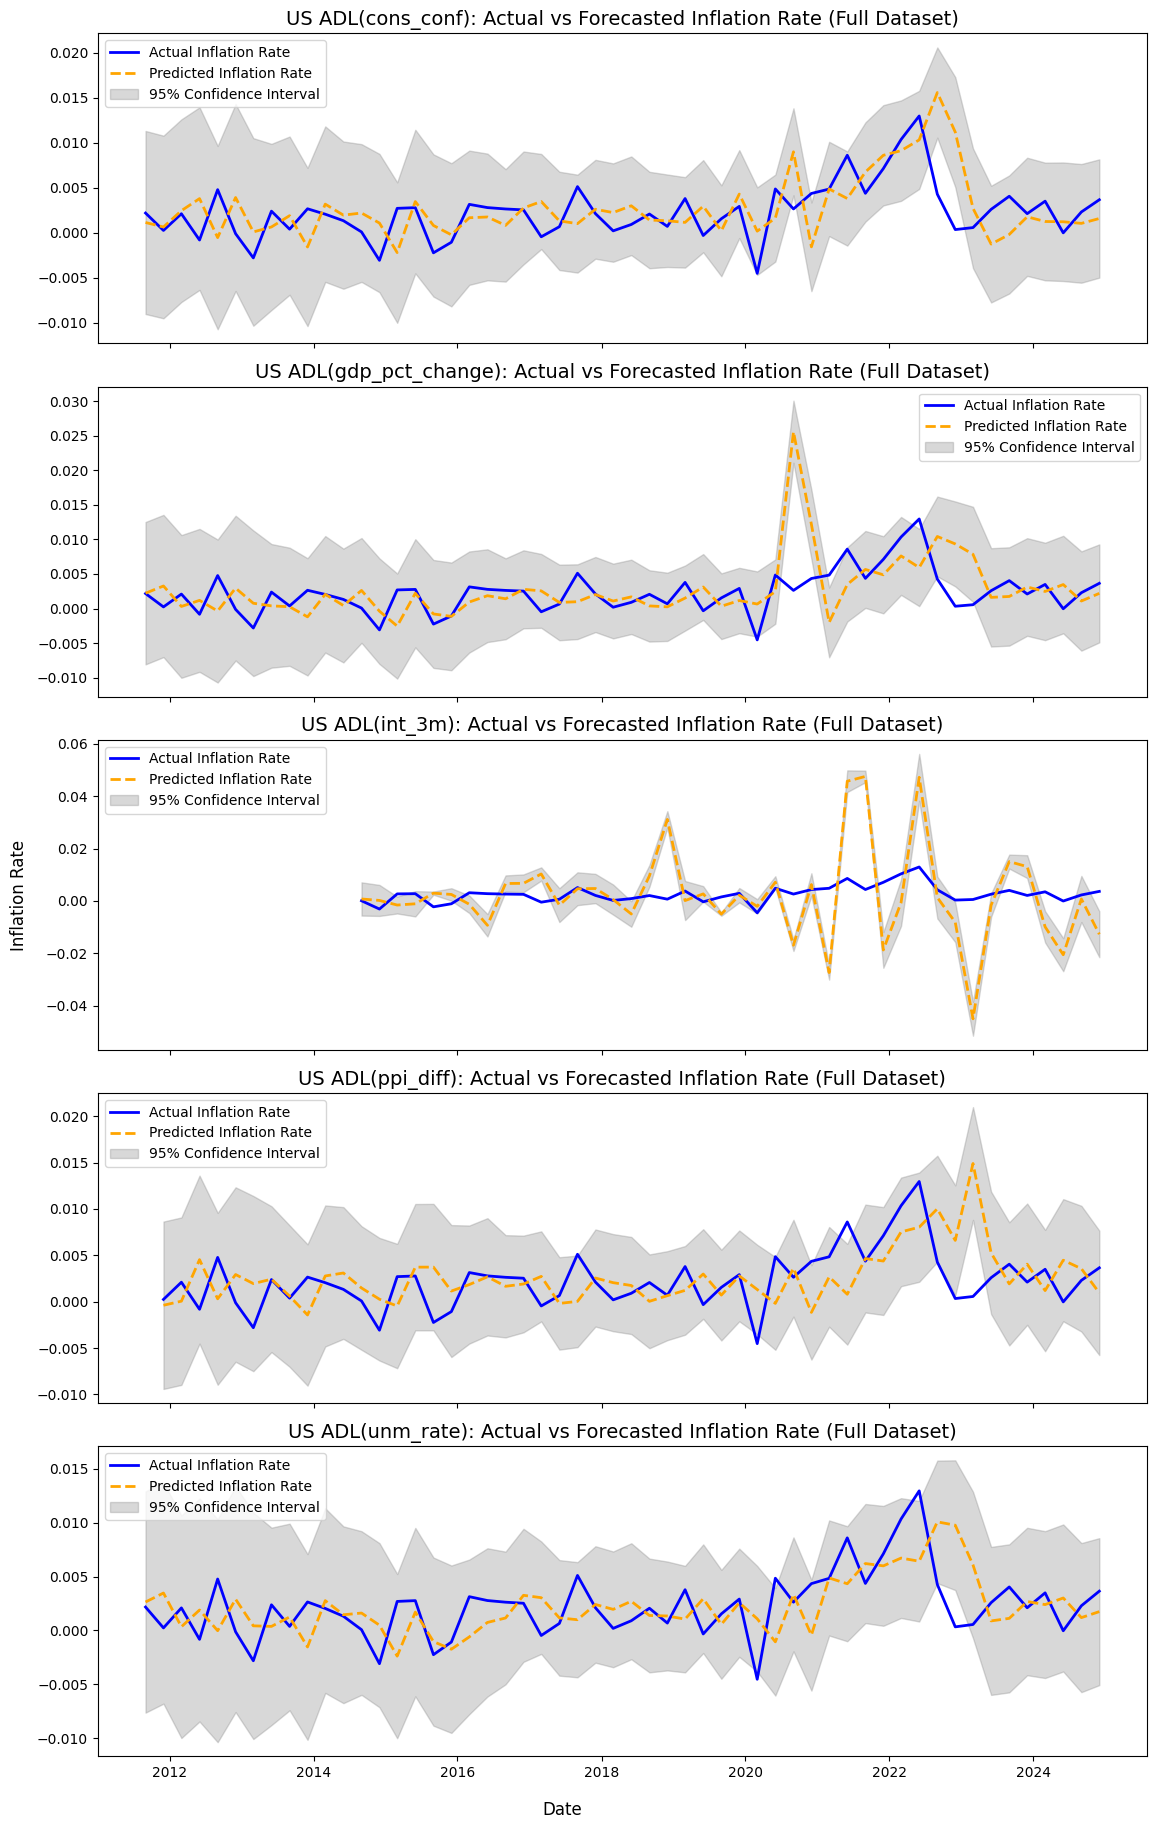

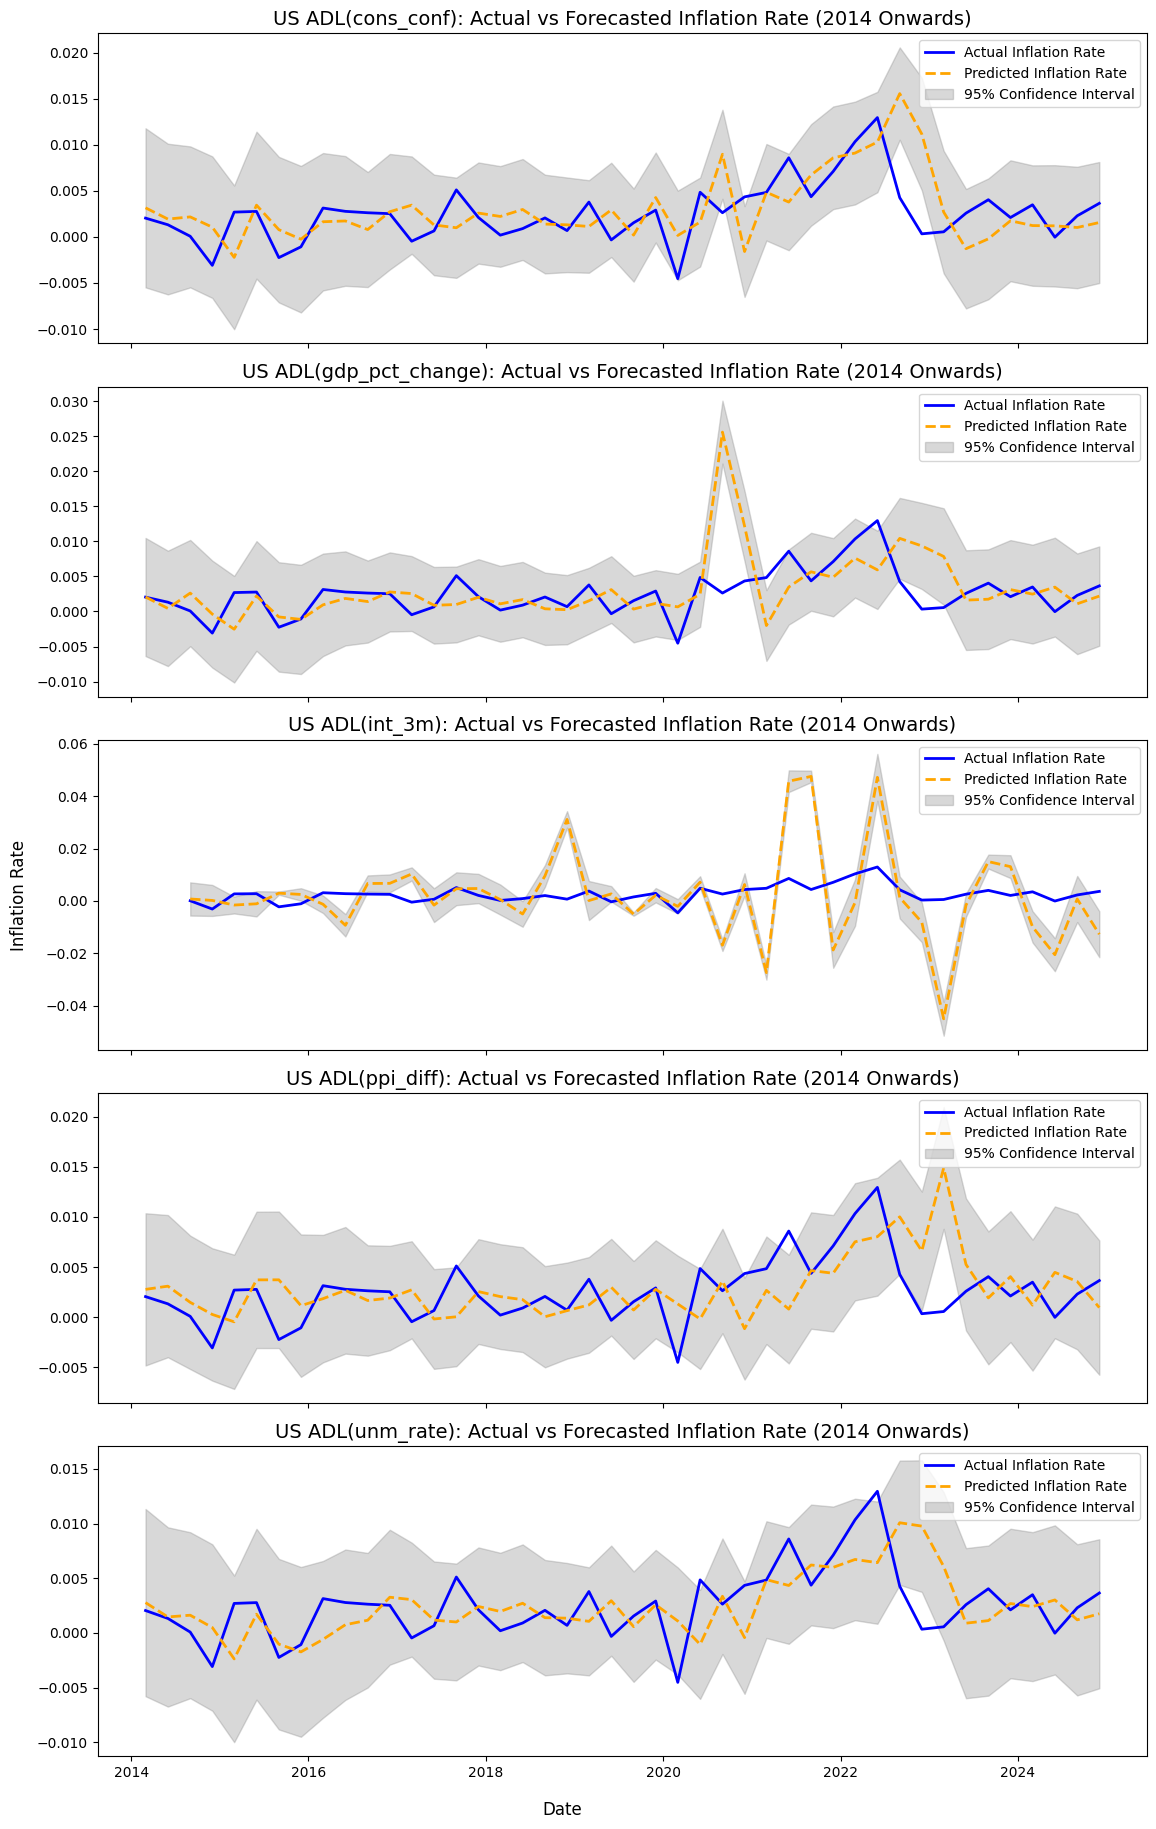

In [36]:
# Ensure the 'Date' column is in datetime format
us_adl_forecast_results['Date'] = pd.to_datetime(us_adl_forecast_results['Date'])

# Get the list of unique macroeconomic variables
macro_vars = us_adl_forecast_results['Macro_Variable'].unique()

# Create subplots: one for each macroeconomic variable
fig, axes = plt.subplots(len(macro_vars), 1, figsize=(12, 20), sharex=True)

# Loop through each macroeconomic variable and plot
for i, macro_var in enumerate(macro_vars):
    # Filter the results for the current macroeconomic variable
    macro_results = us_adl_forecast_results[us_adl_forecast_results['Macro_Variable'] == macro_var]
    
    # Plot actual vs. predicted inflation rate
    axes[i].plot(macro_results['Date'], macro_results['Actual_infl_rate'], label='Actual Inflation Rate', color='blue', linewidth=2)
    axes[i].plot(macro_results['Date'], macro_results['Forecast_infl_rate'], label='Predicted Inflation Rate', color='orange', linestyle='--', linewidth=2)
    
    # Add 95% confidence intervals
    axes[i].fill_between(macro_results['Date'], 
                         macro_results['Lower_95_CI'], 
                         macro_results['Upper_95_CI'], 
                         color='gray', alpha=0.3, label='95% Confidence Interval')
    
    # Add title for each subplot
    axes[i].set_title(f'US ADL({macro_var}): Actual vs Forecasted Inflation Rate (Full Dataset)', fontsize=14)
    
    # Add legend to each subplot
    axes[i].legend(fontsize=10)
    
    # Format x-axis ticks to improve readability
    axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a common x-axis and y-axis label
fig.text(0.5, 0.04, 'Date', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Inflation Rate', va='center', rotation='vertical', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

# Show the plot
plt.show()





# Filter data from 2014 onwards
us_adl_forecast_results_2014 = us_adl_forecast_results[us_adl_forecast_results['Date'] >= '2014-01-01']

# Get the list of unique macroeconomic variables
macro_vars = us_adl_forecast_results_2014['Macro_Variable'].unique()

# Create subplots: one for each macroeconomic variable
fig, axes = plt.subplots(len(macro_vars), 1, figsize=(12, 20), sharex=True)

# Loop through each macroeconomic variable and plot
for i, macro_var in enumerate(macro_vars):
    # Filter the results for the current macroeconomic variable
    macro_results = us_adl_forecast_results_2014[us_adl_forecast_results_2014['Macro_Variable'] == macro_var]
    
    # Plot actual vs. predicted inflation rate
    axes[i].plot(macro_results['Date'], macro_results['Actual_infl_rate'], label='Actual Inflation Rate', color='blue', linewidth=2)
    axes[i].plot(macro_results['Date'], macro_results['Forecast_infl_rate'], label='Predicted Inflation Rate', color='orange', linestyle='--', linewidth=2)
    
    # Add 95% confidence intervals
    axes[i].fill_between(macro_results['Date'], 
                         macro_results['Lower_95_CI'], 
                         macro_results['Upper_95_CI'], 
                         color='gray', alpha=0.3, label='95% Confidence Interval')
    
    # Add title for each subplot
    axes[i].set_title(f'US ADL({macro_var}): Actual vs Forecasted Inflation Rate (2014 Onwards)', fontsize=14)
    
    # Add legend to each subplot
    axes[i].legend(fontsize=10)
    
    # Format x-axis ticks to improve readability
    axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a common x-axis and y-axis label
fig.text(0.5, 0.04, 'Date', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Inflation Rate', va='center', rotation='vertical', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

# Show the plot
plt.show()